In [554]:
import proplot as pplt
import pandas as pd 
import pvlib
import os
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import cluster
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


# Fit Parameters

In [577]:
cec_df = pd.read_csv(os.path.join("..","workbench","device","default_devices","cec_database_local.csv"),index_col="Unnamed: 0").transpose()

cec_full = pd.read_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/module_data/cec_full_module_Data.csv")
useful = cec_full[['Vpmax [V]', 'Ipmax [A]', 'Nameplate Voc [V]', 'Nameplate Isc [A]', 'alpha_Isc [%/C]', 'beta_Voc [%/C]', 'N_s']].dropna().index

module_data = cec_full.iloc[useful].reset_index(drop=True)
numeric_cols = ['nameplate Pmax [W]', 'PTC', 'area [m2]', 'N_s', 'N_p', 'Nameplate Isc [A]', 
                'Nameplate Voc [V]', 'Nameplate Ipmax [A]', 'Nameplate Vpmax [V]',
                'Average NOCT [C]', 'gamma_pmax [%/C]', 'alpha_Isc [%/C]',
                'beta_Voc [%/C]', 'alpha_Ipmax [%/C]', 'beta_Vpmax [%/C]', 'Ipmax [A]',
                'Vpmax [V]', 'Ipmax_NOCT [A]', 'Vpmax_NOCT [V]', 
                'short length [m]', 'long length [m]', 'geometric multiplier']
nec_cols = ['Nameplate Vpmax [V]', 'Nameplate Ipmax [A]', 'Nameplate Voc [V]', 'Nameplate Isc [A]', 'alpha_Isc [%/C]', 'beta_Voc [%/C]', 'N_s']
for col in nec_cols:
    module_data[col] = pd.to_numeric(module_data[col])

module_data['beta_Voc [V/C]'] = module_data['Nameplate Voc [V]'] * (module_data['beta_Voc [%/C]'] / 100)
module_data['alpha_Isc [A/C]'] = module_data['Nameplate Isc [A]'] * (module_data['alpha_Isc [%/C]'] / 100)

/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_7377/2967541781.py:3: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  cec_full = pd.read_csv("/Users/jmccarty/Desktop/cec_full_module_Data.csv")


In [233]:
module_data['tech_combined'] = (module_data['Technology'] + module_data['Family'])

module_data.to_clipboard()
# edit manually

In [586]:
def calc_module_dimensions(cell_width, ncols, col_space, cell_height, nrows, row_space, frame_thickness):
    if cell_width!=cell_height:
        n_frames = 3
    else:
        n_frames = 2
    module_width = (cell_width * ncols) + ((ncols+2)*col_space) + (frame_thickness*n_frames)
    module_height = (cell_height * nrows) + ((nrows+2)*row_space) + (frame_thickness*n_frames)
    module_area = (module_width*module_height) * 1e-6
    return module_width, module_height, module_area
    
def calc_efficiency(device):
    if type(device) is dict:
        pass
    else:
        device = device.iloc[0].to_dict()
    # calc_desoto
    IL,Io,rs,rsh,nNsVth = pvlib.pvsystem.calcparams_desoto(
        1000,
        25,
        alpha_sc=device["desoto_short_circuit_temp_coe_alpha_sc"],
        a_ref=device["desoto_diode_factor_a_ref"],
        I_L_ref=device["desoto_photocurrent_I_L_ref"],
        I_o_ref=device["desoto_saturation_current_I_o_ref"],
        R_sh_ref=device["desoto_shunt_resist_R_sh_ref"],
        R_s=device["desoto_series_resist_R_s_ref"],
        EgRef=device["desoto_energy_bandgap_Egref"],
        dEgdT=device["desoto_bandgap_temp_coe_dEgdT"],
    )
    
    
    # calc_bishop_mpp
    i,v,p = pvlib.singlediode.bishop88_mpp(IL,Io,rs,rsh,nNsVth, 
                                   
                                   breakdown_factor=device['bishop_breakdown_factor'], 
                                   breakdown_voltage=device['bishop_breakdown_voltage'], 
                                   breakdown_exp=device['bishop_breakdown_exp'], 
                                   method='newton')
    total_cell_area = (device['general_cell_area_mm2_typical'] * 1e-6) * (device['module_shape_N_columns_typical'] * device['module_shape_N_rows_typical'])
    cell_efficiency = round((p / total_cell_area) / 1000,3)
    module_efficiency = round((p / device['module_shape_area_m2']) / 1000,3)
    return p,cell_efficiency,module_efficiency

def extract_core_params(df, name, description, ncols, nrows, cell_height, cell_width, col_spacing, row_spacing, frame_thickness,flexible=False):
    rename_dict = {
        "manufacturer": "irrelevant",
        "model number": "irrelevant",
        "description": "irrelevant",
        "safety certification": "irrelevant",
        "nameplate Pmax [W]": "irrelevant",
        "PTC [W]": "irrelevant",
        "Notes": "irrelevant",
        "Family": "irrelevant",
        "Technology": "irrelevant",
        "area [m2]": "irrelevant",
        "N_s": "bishop_N_s_typical",
        "N_p": "bishop_N_p_typical",
        "BIPV": "irrelevant",
        "Nameplate Isc [A]": "irrelevant",
        "Nameplate Voc [V]": "irrelevant",
        "Nameplate Ipmax [A]": "irrelevant",
        "Nameplate Vpmax [V]": "irrelevant",
        "Average NOCT [C]": "performance_NOCT_T_degC",
        "gamma_pmax [%/C]": "performance_temp_coe_gamma_pctC",
        "alpha_Isc [%/C]": "desoto_short_circuit_temp_coe_alpha_sc",
        "beta_Voc [%/C]": "irrelevant",
        "alpha_Ipmax [%/C]": "irrelevant",
        "beta_Vpmax [%/C]": "irrelevant",
        "Ipmax [A]": "irrelevant",
        "Vpmax [V]": "irrelevant",
        "Ipmax_NOCT [A]": "irrelevant",
        "Vpmax_NOCT [V]": "irrelevant",
        "mounting": "irrelevant",
        "type": "irrelevant",
        "short length [m]": "irrelevant",
        "long length [m]": "irrelevant",
        "geometric multiplier": "irrelevant",
        "beta_Voc [V/C]": "irrelevant",
        "alpha_Isc [A/C]": "irrelevant",
        "tech_combined": "irrelevant",
        "cell_type": "general_cell_type",
        "year_added": "irrelevant",
        "bifacial": "irrelevant",
        "heterojunction": "general_heterojunction",
        "STC [W]": "irrelevant",
        "breakdown_factor": "bishop_breakdown_factor",
        "breakdown_exp": "bishop_breakdown_exp",
        "breakdown_voltage": "bishop_breakdown_voltage",
        "eg_ref": "desoto_energy_bandgap_Egref",
        "dEgdT": "desoto_bandgap_temp_coe_dEgdT",
        "photocurrent (I_L)": "desoto_photocurrent_I_L_ref",
        "saturation_current (I_o)": "desoto_saturation_current_I_o_ref",
        "resistance_series (R_s)": "desoto_series_resist_R_s_ref",
        "resistance_shunt (R_sh)": "desoto_shunt_resist_R_sh_ref",
        "a_ref": "desoto_diode_factor_a_ref",
        "adjust": "irrelevant",
        "FF_STC": "irrelevant",
        "FF_NOCT": "irrelevant",
        "Pmp_STC_sqm": "irrelevant",
        "Pmp_NOCT_sqm": "irrelevant",
        "Pmp_sqm_ratio": "irrelevant",
        "FF_ratio": "performance_thermal_resilience",
    }
    df = df.rename(columns=rename_dict)
    df["desoto_short_circuit_temp_coe_alpha_sc"] = df["desoto_short_circuit_temp_coe_alpha_sc"] / 100
    
    df['general_description'] = description
    
    # cell stuff
    df['general_cell_height_mm_typical'] = cell_height
    df['general_cell_width_mm_typical'] = cell_width
    df['general_cell_area_mm2_typical'] = df['general_cell_width_mm_typical'] * df['general_cell_height_mm_typical'] 
    
    # module stuff
    df['module_shape_N_columns_typical'] = ncols
    df['module_shape_N_rows_typical'] = nrows
    df['module_shape_column_spacing_mm'] = col_spacing
    df['module_shape_row_spacing_mm'] = row_spacing
    df['module_shape_frame_thickness_mm'] = frame_thickness
        
    if (df['module_shape_N_columns_typical'].iloc[0]==1) or (df['module_shape_N_rows_typical'].iloc[0]==1):
        df['general_monolithic'] = True
        if df['module_shape_N_columns_typical'].iloc[0] == 1:
            df['module_n_subcell_rows_typical'] = 1 
            df['module_n_subcell_cols_typical'] = 5
        else: #(nrows==1)
            df['module_n_subcell_rows_typical'] = 5
            df['module_n_subcell_cols_typical'] = 1
    else:
        df['general_monolithic'] = False
        df['module_n_subcell_rows_typical'] = 1
        df['module_n_subcell_cols_typical'] = 1
        
    w, h, a = calc_module_dimensions(cell_width, ncols, col_spacing, cell_height, nrows, row_spacing, frame_thickness)
    df['module_shape_width_mm'] = w
    df['module_shape_height_mm'] = h
    df['module_shape_area_m2'] = a
    
    df['module_shape_flex'] = flexible
    
    df['performance_power_W_ref'], df['performance_cell_efficiency_ref'], df['performance_module_efficiency_ref'] = calc_efficiency(df)

    df = df[[col for col in df.columns if col != "irrelevant"]].iloc[0]
    df = df.sort_index()
    return df.rename(name)


def iv_string_module(module, conditions):
    sde_args = pvlib.pvsystem.calcparams_desoto(
        conditions[0],
        conditions[1],
        alpha_sc=module["alpha_Isc [%/C]"] / 100,
        a_ref=module["a_ref"],
        I_L_ref=module["photocurrent (I_L)"],
        I_o_ref=module["saturation_current (I_o)"],
        R_sh_ref=module["resistance_shunt (R_sh)"],
        R_s=module["resistance_series (R_s)"],
        EgRef=module["eg_ref"],
        dEgdT=module["dEgdT"],
    )
    # sde_args has values:
    # (photocurrent, saturation_current, resistance_series,
    # resistance_shunt, nNsVth)

    # Use Bishop's method to calculate points on the IV curve with V ranging
    # from the reverse breakdown voltage to open circuit
    kwargs = {
        "breakdown_factor": 0.0,
        "breakdown_exp": 3.28,
        "breakdown_voltage": -5.5,
    }
    v_oc = pvlib.singlediode.bishop88_v_from_i(0.0, *sde_args, **kwargs)

    # build voltage array for the diode
    vd = np.linspace(0.99 * kwargs["breakdown_voltage"], v_oc, 500)

    ivcurve_i_whole, ivcurve_v_whole, _ = pvlib.singlediode.bishop88(
        vd, *sde_args, **kwargs
    )
    ivcurve_i_cell, ivcurve_v_cell = divide_iv_curve(
        ivcurve_i_whole, ivcurve_v_whole, module["N_s"], module["N_p"]
    )

    ivcurve_whole = pd.DataFrame(
        {
            "i": ivcurve_i_whole,
            "v": ivcurve_v_whole,
        }
    )

    ivcurve_cell = pd.DataFrame(
        {
            "i": ivcurve_i_cell,
            "v": ivcurve_v_cell,
        }
    )

    return ivcurve_cell  # (",".join(ivcurve_cell['i'].astype(str).tolist()),",".join(ivcurve_cell['v'].astype(str).tolist()))


def calcMPP(Isys, Vsys):
    """from PVmismatch"""
    Psys = Isys * Vsys
    mpp = np.argmax(Psys)
    if Psys[mpp] == 0:
        Imp, Vmp, Pmp, Isc, Voc, FF = 0, 0, 0, 0, 0, 0
    else:
        P = Psys[mpp - 1 : mpp + 2]
        V = Vsys[mpp - 1 : mpp + 2]
        I = Isys[mpp - 1 : mpp + 2]

        if any(P) == 0 or any(V) == 0 or any(I) == 0:
            Imp, Vmp, Pmp, Isc, Voc, FF = 0, 0, 0, 0, 0, 0
        else:
            # calculate derivative dP/dV using central difference
            dP = np.diff(P, axis=0)  # size is (2, 1)
            dV = np.diff(V, axis=0)  # size is (2, 1)
            if any(dP) == 0 or any(dV) == 0:
                Imp, Vmp, Pmp, Isc, Voc, FF = 0, 0, 0, 0, 0, 0
            else:
                # Pv = dP / dV  # size is (2, 1)
                Pv = np.divide(dP, dV, out=np.zeros_like(dP), where=dV != 0)
                # dP/dV is central difference at midpoints,
                Vmid = (V[1:] + V[:-1]) / 2.0  # size is (2, 1)
                Imid = (I[1:] + I[:-1]) / 2.0  # size is (2, 1)
                # interpolate to find Vmp

                Vmp = (
                    -Pv[0] * np.diff(Vmid, axis=0) / np.diff(Pv, axis=0) + Vmid[0]
                ).item()
                Imp = (
                    -Pv[0] * np.diff(Imid, axis=0) / np.diff(Pv, axis=0) + Imid[0]
                ).item()
                # calculate max power at Pv = 0
                Pmp = Imp * Vmp

    return dict(zip(["imp", "vmp", "pmp"], [Imp, Vmp, Pmp]))


def calc_FF(V_mp, I_mp, V_oc, I_sc):
    return (V_mp * I_mp) / (V_oc * I_sc)


def divide_iv_curve(i, v, n_s, n_p):
    i = i / n_p
    v = v / n_s
    return i, v


def map_tech(combined_tech, new_tech):
    tech_mapper = {
        "Mono-c-SiMonocrystalline": "monoSi",
        "Multi-c-SiPolycrystalline": "polySi",
        "Mono-c-SiPolycrystalline": "polySi",
        "Thin FilmThin Film": "mixed",
        "Multi-c-SiMonocrystalline": "monoSi",
        "CdTeThin Film": "cdte",
        "Multi-c-Si Polycrystalline ": "polySi",
        "CIGSThin Film": "cigs",
        "Thin FilmCIGS Thin Film": "cigs",
        "Multi-c-SiHIT-Si Thin Film": "monoSi",
        "Multi-c-SiThin Film": "monoSi",
        "Multi-c-Sipolycrystalline": "polySi",
        "Thin FilmPolycrystalline": "polySi",
    }
    if tech_mapper[combined_tech] == "mixed":
        return new_tech
    else:
        return tech_mapper[combined_tech]


def map_energy_bandgap(cell_type):
    tech = ["monoSi", "polySi", "cigs", "cdte", "amorphous", "cis", "gaas"]
    # https://pubs.acs.org/doi/10.1021/acsenergylett.0c01790
    # https://pvlib-python.readthedocs.io/en/v0.9.0/generated/pvlib.pvsystem.calcparams_desoto.html
    Eg_Ref_list = [1.121, 1.121, 1.15, 1.475, 1.75, 1.010, 1.424]
    # cigs and amorphous could not find
    deEgdT_ref_list = [
        -0.0002677,
        -0.0002677,
        -0.0002677,
        -0.0003,
        -0.0002677,
        -0.00011,
        -0.000433,
    ]

    eg_ref = dict(zip(tech, Eg_Ref_list))[cell_type]
    dEgdT = dict(zip(tech, deEgdT_ref_list))[cell_type]

    return eg_ref, dEgdT


def map_breakdown(cell_type, option):
    tech = ["monoSi", "polySi", "cigs", "cdte", "amorphous", "cis", "gaas"]

    default_values = {
        "breakdown_factor": 2e-3,
        "breakdown_exp": 3,
        "breakdown_voltage": -15,
    }
    return default_values[option]

In [56]:

updated_module_data = pd.read_csv(
    "/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/module_data/cec_full_module_data_edited.csv"
)

updated_module_data["cell_type"] = updated_module_data.apply(
    lambda x: map_tech(x["tech_combined"], x["cell_type"]), axis=1
)




/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_5216/2341935088.py:1: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  updated_module_data = pd.read_csv(


In [57]:
# add bifacial indicator
bifacial_idx = updated_module_data[updated_module_data['description'].str.contains("bifacial").fillna(False)].index
monofacial_idx = updated_module_data[~updated_module_data['description'].str.contains("bifacial").fillna(False)].index
bifacial = updated_module_data.iloc[bifacial_idx].reset_index(drop=True)
bifacial['bifacial'] = True
monofacial = updated_module_data.iloc[monofacial_idx].reset_index(drop=True)
monofacial['bifacial'] = False

w_bifacial = pd.concat([monofacial,bifacial],axis=0,ignore_index=True)

In [58]:
# add tandem and HIT indicator
hjt_idx = w_bifacial[w_bifacial['description'].str.lower().str.contains("hjt").fillna(False)].index.tolist()
hit_idx = w_bifacial[w_bifacial['description'].str.contains("HIT").fillna(False)].index.tolist()
tandem_idx = w_bifacial[w_bifacial['description'].str.lower().str.contains("tandem").fillna(False)].index.tolist()
hetero_idx = w_bifacial[w_bifacial['description'].str.lower().str.contains("hetero").fillna(False)].index.tolist()
multi_junction_idx = list(set(hjt_idx+hit_idx+tandem_idx+hetero_idx))

hetero = w_bifacial.loc[multi_junction_idx].reset_index(drop=True)
hetero['heterojunction'] = True
single = w_bifacial.loc[w_bifacial.index.difference(multi_junction_idx)].reset_index(drop=True)
single['heterojunction'] = False

w_junction = pd.concat([single,hetero],axis=0,ignore_index=True)

# there seems to be an error where the nampleate power is sometimes incorrectly specificed in the csv
w_junction['STC [W]'] = w_junction['Nameplate Ipmax [A]'] * w_junction['Nameplate Vpmax [V]']



In [59]:
bandgap_data = w_junction.apply(lambda x: map_energy_bandgap(x['cell_type']),axis=1)
bandgap_data = bandgap_data.apply(pd.Series)
bandgap_data.columns=['eg_ref','dEgdT']

w_junction['breakdown_factor'] = w_junction.apply(lambda x: map_breakdown(x['cell_type'],'breakdown_factor'),axis=1)
w_junction['breakdown_exp'] = w_junction.apply(lambda x: map_breakdown(x['cell_type'],'breakdown_exp'),axis=1)
w_junction['breakdown_voltage'] = w_junction.apply(lambda x: map_breakdown(x['cell_type'],'breakdown_voltage'),axis=1)
w_junction['eg_ref'] = bandgap_data['eg_ref']
w_junction['dEgdT'] = bandgap_data['dEgdT']

In [60]:
w_junction.to_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/cec_data_231023.csv",index=None)

In [62]:
# load in labeled data
device_data = pd.read_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/cec_data_231023.csv")

# filter out bifacial and hetero junction
single_device = device_data[(device_data['bifacial']==False) & (device_data['heterojunction']==False)]
tandem_device = device_data[(device_data['bifacial']==False) & (device_data['heterojunction']==True)]

/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_5216/2653282379.py:2: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  device_data = pd.read_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/cec_data_231023.csv")


In [66]:
tandem_device['cell_type'].value_counts()

cell_type
monoSi       143
amorphous      7
Name: count, dtype: int64

<AxesSubplot:xlabel='cell_type'>

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/

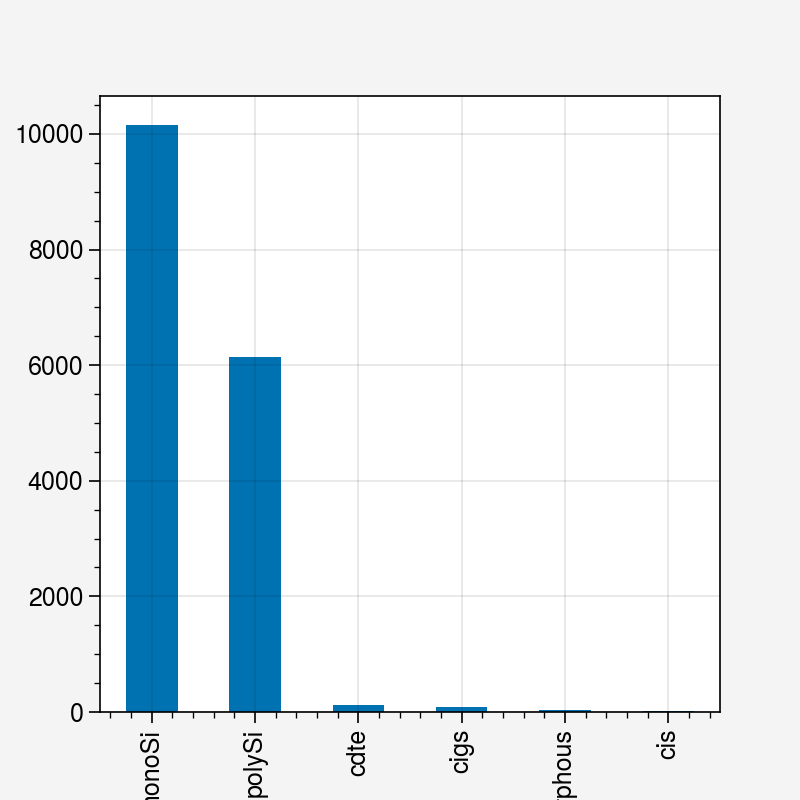

In [63]:
# get cell types
cell_types = single_device.cell_type.unique()
single_device.cell_type.value_counts().plot.bar()

## Test if N_p assumption works

Testing showed the fitting params on single cells will work sometimes, but not often enough to warrant using the approach. Therefore all cells will be charaterised using the whole module IV divided by N_s and N_p

In [527]:
device_data_type = single_device[single_device['cell_type']=='monoSi']
module = device_data_type[device_data_type['N_p']>0].iloc[10]
# module = row.copy()
module[['description','cell_type','Nameplate Vpmax [V]','Nameplate Ipmax [A]','N_s','N_p',
        'alpha_Isc [%/C]','beta_Voc [%/C]','gamma_pmax [%/C]']]

description            250 W Monocrystalline Module
cell_type                                    monoSi
Nameplate Vpmax [V]                            30.6
Nameplate Ipmax [A]                            8.17
N_s                                              60
N_p                                             1.0
alpha_Isc [%/C]                             0.05373
beta_Voc [%/C]                              -0.3564
gamma_pmax [%/C]                            -0.4796
Name: 18, dtype: object

In [505]:
# fit single cell
params_single_cell = pvlib.ivtools.sdm.fit_cec_sam(
                celltype=module['cell_type'],
                v_mp=module["Nameplate Vpmax [V]"] / module["N_s"],
                i_mp=module["Nameplate Ipmax [A]"] / module["N_p"],
                v_oc=module["Nameplate Voc [V]"] / module["N_s"],
                i_sc=module["Nameplate Isc [A]"] / module["N_p"],
                alpha_sc=(module["Nameplate Isc [A]"] / module["N_p"]) * (module["alpha_Isc [%/C]"] / 100),
                beta_voc=(module["Nameplate Voc [V]"] / module["N_s"]) * (module["beta_Voc [%/C]"] / 100),
                gamma_pmp=module["gamma_pmax [%/C]"],
                cells_in_series=1,
            )

6parsolve simulation error
 : Could not solve, sanity check failed (-1): a < 0.05 || a > 15.0


RuntimeError: Parameter estimation failed

In [522]:
# fit whole module
params_whole_module = pvlib.ivtools.sdm.fit_cec_sam(
                celltype=module['cell_type'],
                v_mp=module["Nameplate Vpmax [V]"],
                i_mp=module["Nameplate Ipmax [A]"],
                v_oc=module["Nameplate Voc [V]"],
                i_sc=module["Nameplate Isc [A]"],
                alpha_sc=(module["Nameplate Isc [A]"]) * (module["alpha_Isc [%/C]"] / 100),
                beta_voc=(module["Nameplate Voc [V]"]) * (module["beta_Voc [%/C]"] / 100),
                gamma_pmp=module["gamma_pmax [%/C]"],
                cells_in_series=module['N_s'],
            )

In [523]:
# adjust the reference parameters according to the operating
# conditions using the De Soto model:
params = params_whole_module
sde_args = pvlib.pvsystem.calcparams_desoto(
    1000,
    25,
    alpha_sc=module['alpha_Isc [%/C]'] / 100,
    a_ref=params[4],
    I_L_ref=params[0],
    I_o_ref=params[1],
    R_sh_ref=params[3],
    R_s=params[2],
    EgRef=1.121,
    dEgdT=-0.0002677
)
# sde_args has values:
# (photocurrent, saturation_current, resistance_series,
# resistance_shunt, nNsVth)

# Use Bishop's method to calculate points on the IV curve with V ranging
# from the reverse breakdown voltage to open circuit
kwargs = {
    'breakdown_factor': 0.0,
    'breakdown_exp': 3.28,
    'breakdown_voltage': -5.5,
}
v_oc = pvlib.singlediode.bishop88_v_from_i(
    0.0, *sde_args, **kwargs
)

# build voltage array for the diode
vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, 1000)

ivcurve_i_whole, ivcurve_v_whole, _ = pvlib.singlediode.bishop88(vd, *sde_args, **kwargs)
ivcurve_i_cell, ivcurve_v_cell = divide_iv_curve(ivcurve_i_whole, ivcurve_v_whole, 
                                                 module['N_s'], module['N_p'])

ivcurve_whole = pd.DataFrame({
        'i': ivcurve_i_whole,
        'v': ivcurve_v_whole,
    })

ivcurve_cell = pd.DataFrame({
        'i': ivcurve_i_cell,
        'v': ivcurve_v_cell,
    })



/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_7377/2258924117.py:15: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


SubplotGrid(nrows=1, ncols=2, length=2)

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

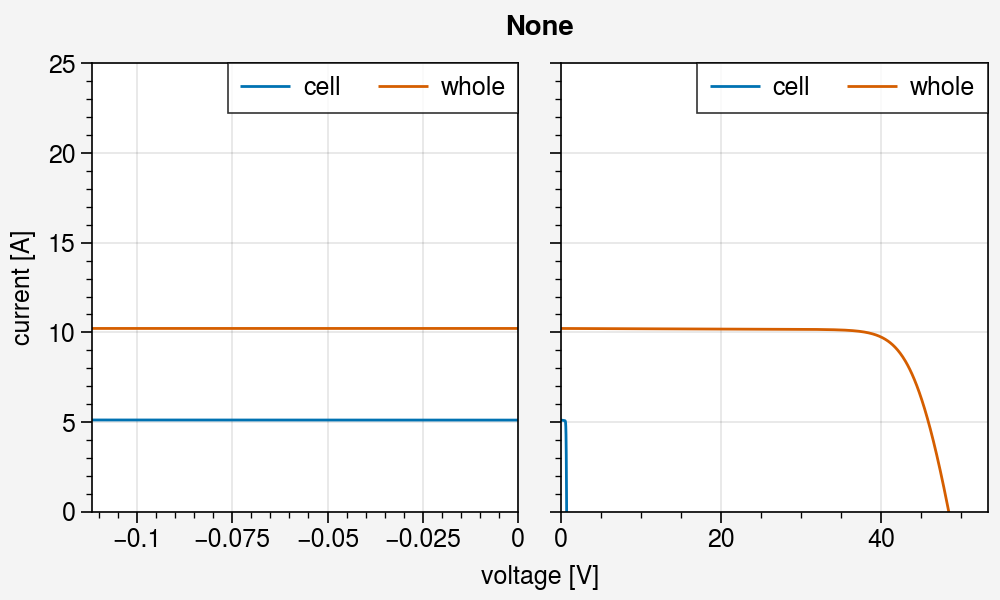

In [725]:
# plot to show that the combined cell curves match the STC curve for the whole module
def plot_curves(dfs, labels, title, lws):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = pplt.subplots(nrows=1, ncols=2, sharey=True, figsize=(5, 3))
    for df, label, lw in zip(dfs, labels, lws):
        df.plot('v', 'i', label=label, ax=axes[0], lw=lw)
        df.plot('v', 'i', label=label, ax=axes[1], lw=lw)
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 25])
        axes[1].set_xlim([0, df['v'].max()*1.1])
    axes[0].set_ylabel('current [A]')
    axes[0].set_xlabel('voltage [V]')
    axes[1].set_xlabel('voltage [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes

plot_curves([ivcurve_cell,ivcurve_whole],['cell','whole'],'None',[1,1])

# Fit Params for Dataset

## Single Cell

In [428]:
input_cols = ['Nameplate Vpmax [V]','Nameplate Ipmax [A]','Nameplate Voc [V]','Nameplate Isc [A]',
              'alpha_Isc [%/C]','beta_Voc [%/C]','gamma_pmax [%/C]','N_s','N_p','cell_type',
              'eg_ref','dEgdT', 'breakdown_factor', 'breakdown_exp', 'breakdown_voltage']
params_names = ['photocurrent (I_L)', 'saturation_current (I_o)', 
                'resistance_series (R_s)','resistance_shunt (R_sh)', 
                'a_ref','adjust']
failed = []
missing = []
results = []

for idx, row in single_device.iterrows():
    if pd.isna(row[input_cols]).sum()>0:
        missing.append(idx)
        results.append(tuple([np.nan] * 6))
    else:
        try:
            params = pvlib.ivtools.sdm.fit_cec_sam(
                celltype=row['cell_type'],
                v_mp=row["Nameplate Vpmax [V]"],
                i_mp=row["Nameplate Ipmax [A]"],
                v_oc=row["Nameplate Voc [V]"],
                i_sc=row["Nameplate Isc [A]"],
                alpha_sc=(row["Nameplate Isc [A]"]) * (row["alpha_Isc [%/C]"] / 100),
                beta_voc=(row["Nameplate Voc [V]"]) * (row["beta_Voc [%/C]"] / 100),
                gamma_pmp=row["gamma_pmax [%/C]"],
                cells_in_series=row['N_s'],
            )
            results.append(params)
        except RuntimeError:
            failed.append(idx)
            results.append(tuple([np.nan] * 6))
            


print(f"{round(100*(len(failed)/len(single_device)),2)}% failed to converge")
print(f"{round(100*(len(missing)/len(single_device)),2)}% are missing features")
single_device_params = pd.concat([single_device.reset_index(drop=True),pd.DataFrame(results,columns=params_names)],axis=1)


single_device_params.to_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/module_data/cec_full_module_data_with_params.csv")

6parsolve simulation error
 : Could not solve, sanity check failed (-33): abs((P - Pmp) / Pmp) > 0.015


KeyboardInterrupt: 

## Tandem

In [79]:
input_cols = ['Nameplate Vpmax [V]','Nameplate Ipmax [A]','Nameplate Voc [V]','Nameplate Isc [A]',
              'alpha_Isc [%/C]','beta_Voc [%/C]','gamma_pmax [%/C]','N_s','N_p','cell_type',
              'eg_ref','dEgdT', 'breakdown_factor', 'breakdown_exp', 'breakdown_voltage']
params_names = ['photocurrent (I_L)', 'saturation_current (I_o)', 
                'resistance_series (R_s)','resistance_shunt (R_sh)', 
                'a_ref','adjust']

failed = []
missing = []
results = []

for idx, row in tandem_device.iterrows():
    if pd.isna(row[input_cols]).sum()>0:
        missing.append(idx)
        results.append(tuple([np.nan] * 6))
    else:
        try:
            params = pvlib.ivtools.sdm.fit_cec_sam(
                celltype=row['cell_type'],
                v_mp=row["Nameplate Vpmax [V]"],
                i_mp=row["Nameplate Ipmax [A]"],
                v_oc=row["Nameplate Voc [V]"],
                i_sc=row["Nameplate Isc [A]"],
                alpha_sc=(row["Nameplate Isc [A]"]) * (row["alpha_Isc [%/C]"] / 100),
                beta_voc=(row["Nameplate Voc [V]"]) * (row["beta_Voc [%/C]"] / 100),
                gamma_pmp=row["gamma_pmax [%/C]"],
                cells_in_series=row['N_s'],
            )
            results.append(params)
        except RuntimeError:
            failed.append(idx)
            results.append(tuple([np.nan] * 6))
            


print(f"{round(100*(len(failed)/len(tandem_device)),2)}% failed to converge")
print(f"{round(100*(len(missing)/len(tandem_device)),2)}% are missing features")
tandem_device_params = pd.concat([tandem_device.reset_index(drop=True),pd.DataFrame(results,columns=params_names)],axis=1)


tandem_device_params.to_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/module_data/cec_full_module_data_with_params_tandem.csv")

0.0% failed to converge
12.67% are missing features


# Calc NOCT Curves

## Single

In [529]:
single_device_params = pd.read_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/module_data/cec_full_module_data_with_params.csv",index_col="Unnamed: 0")
params_no_nan = single_device_params[~pd.isna(single_device_params['a_ref'])]
new_modules = params_no_nan[params_no_nan['year_added']>2018].reset_index(drop=True)

ff_stc = []
ff_noct = []
power_density_stc = []
power_density_noct = []


for idx, row in new_modules.iterrows():
    I_sc = row['Nameplate Isc [A]'] / row['N_p']
    V_oc = row['Nameplate Voc [V]'] / row['N_s']
    
    # calc STC
    iv_stc = iv_string_module(row, (1000,25))
    mpp_res_stc = calcMPP(iv_stc['i'].values,iv_stc['v'].values)
    ff_stc.append(calc_FF(mpp_res_stc['vmp'], mpp_res_stc['imp'], V_oc, I_sc))
    
    # calc NOCT
    iv_noct = iv_string_module(row, (800,20 + ((row['Average NOCT [C]'] - 20)/80) * 80))
    mpp_res_noct = calcMPP(iv_noct['i'].values,iv_noct['v'].values)
    ff_noct.append(calc_FF(mpp_res_noct['vmp'], mpp_res_noct['imp'], V_oc, I_sc))
    
    # power density
    power_density_stc.append(mpp_res_stc['pmp'] / row['area [m2]'])
    power_density_noct.append(mpp_res_noct['pmp'] / row['area [m2]'])
    
new_modules['FF_STC'] = ff_stc
new_modules['FF_NOCT'] = ff_noct
new_modules['Pmp_STC_sqm'] = power_density_stc
new_modules['Pmp_NOCT_sqm'] = power_density_noct
new_modules['Pmp_sqm_ratio'] = new_modules['Pmp_NOCT_sqm'] / new_modules['Pmp_STC_sqm']
new_modules['FF_ratio'] = new_modules['FF_NOCT'] / new_modules['FF_STC']

/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_5216/2869474184.py:1: DtypeWarning: Columns (7,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  single_device_params = pd.read_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/module_data/cec_full_module_data_with_params.csv",index_col="Unnamed: 0")


<AxesSubplot:title={'center':'n=2892'}, ylabel='W/sqm.'>

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/Caskroom/

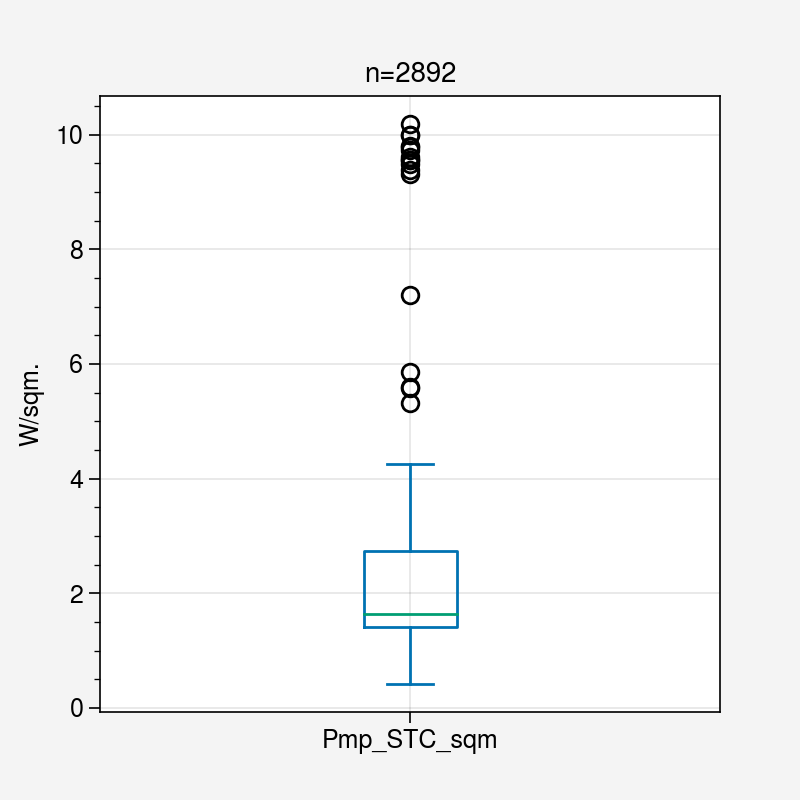

In [45]:
new_modules['Pmp_STC_sqm'].plot.box(ylabel='W/sqm.',title=f"n={len(new_modules)}")

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

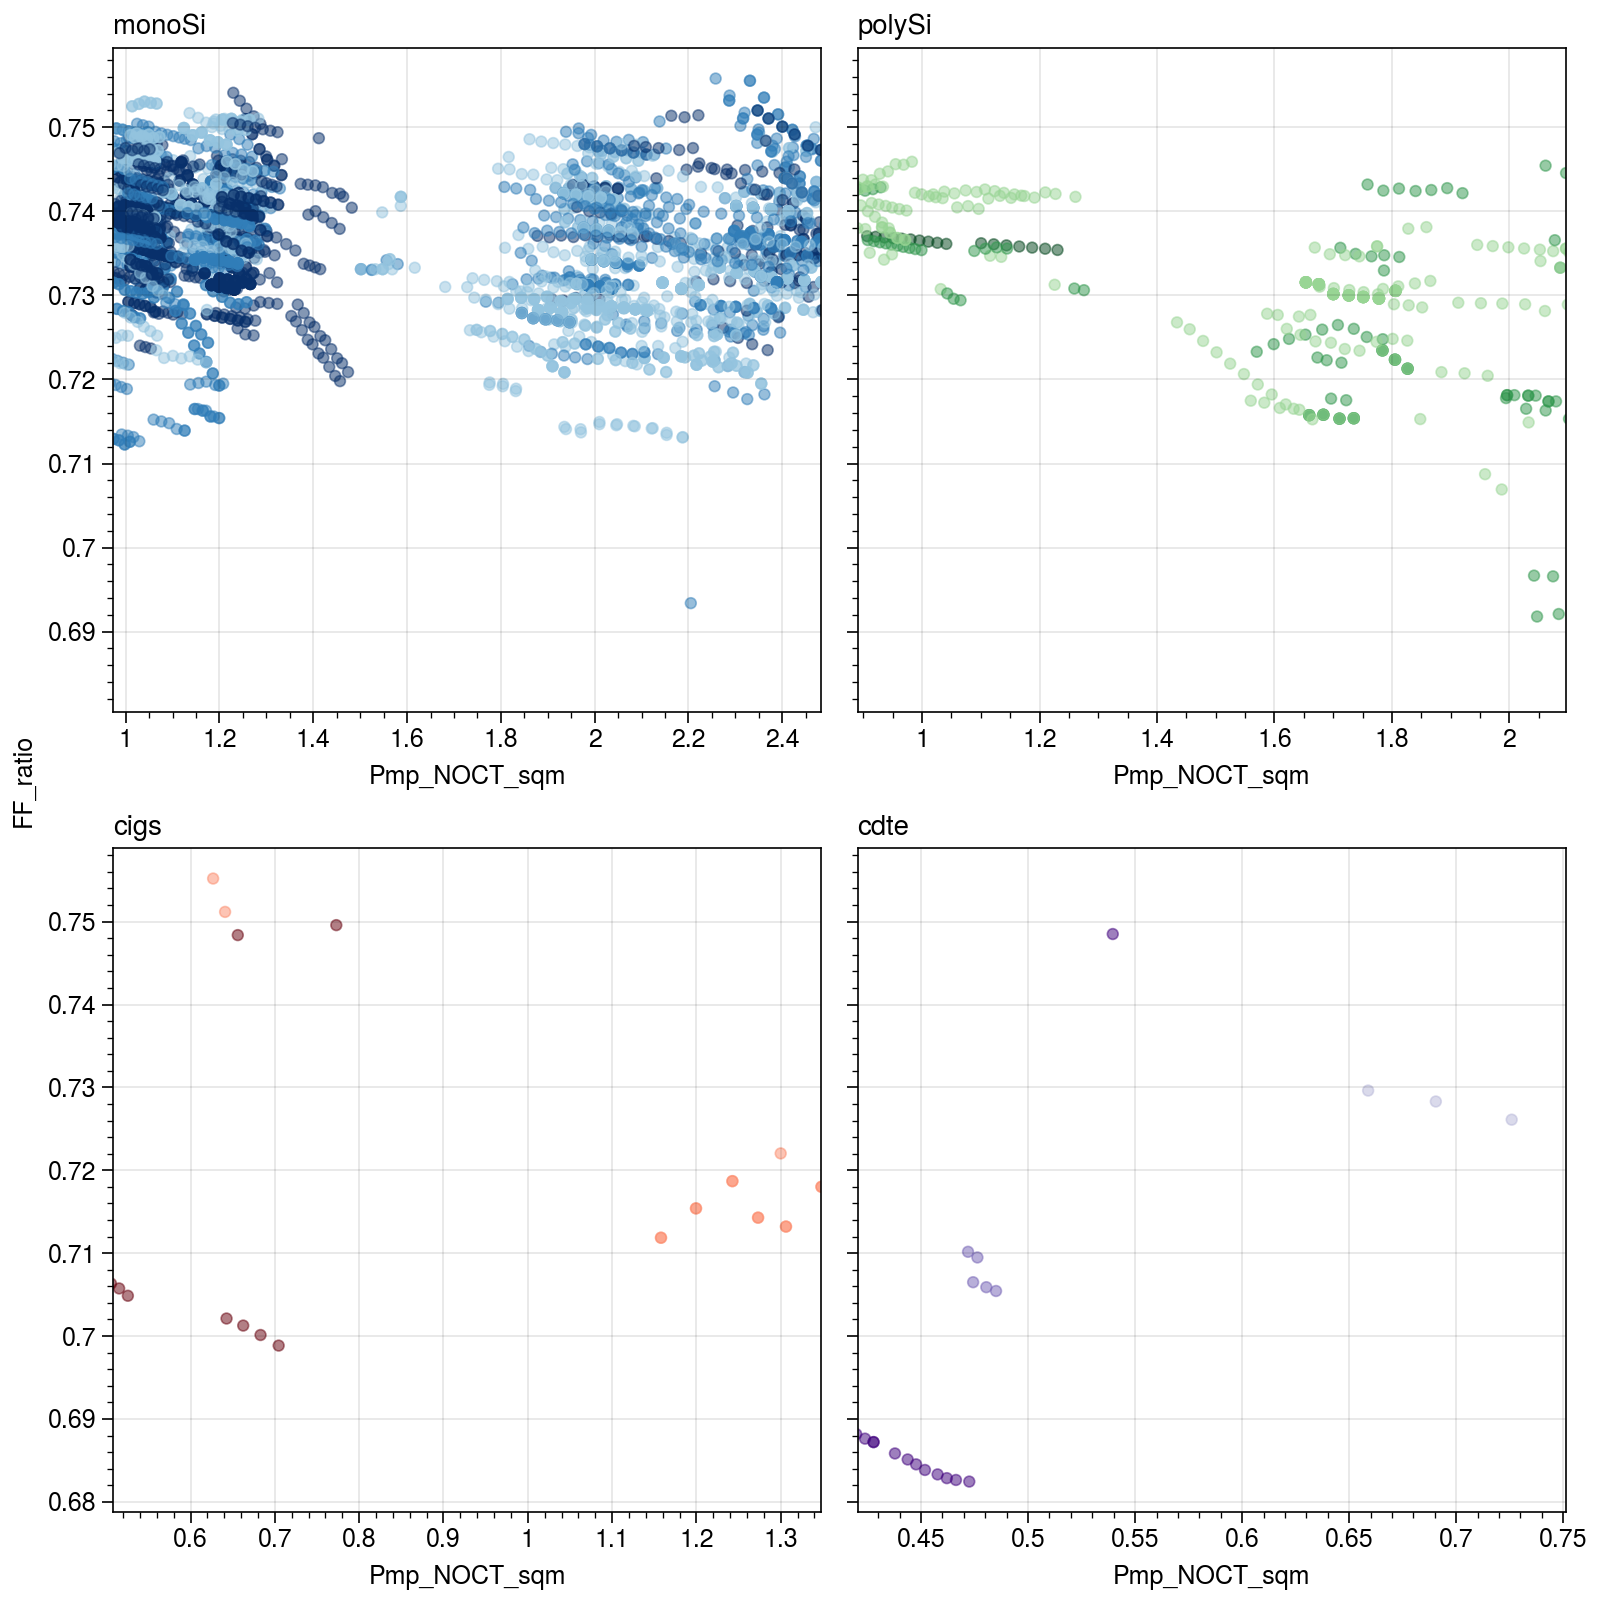

In [99]:
fig,axe = pplt.subplots(nrows=2,ncols=2,figsize=(4*2,4*2),sharex=False, facecolor='white')
ax = axe[0]

a = 0.5
ms = 15


for label, ax, color in zip(['monoSi','polySi','cigs','cdte'],axe,['Blues','Greens','Reds','Purples']):
    plot_data = new_modules[new_modules['cell_type']==label]
    ax.scatter(x=plot_data['Pmp_NOCT_sqm'],
            y=plot_data['FF_ratio'],
            cmap=pplt.get_colors(color,6)[2:],
            c=plot_data['year_added'],alpha=a,s=ms,label=label)
    ax.format(ltitle=label,
              xlim=(plot_data['Pmp_NOCT_sqm'].quantile(0.05),plot_data['Pmp_NOCT_sqm'].quantile(0.95)))


### Typ Mono

In [530]:
final_devices = []

#### half cut

In [531]:

mono = new_modules[new_modules['cell_type']=="monoSi"]
half_cut = mono[mono['Pmp_NOCT_sqm']<1.6]
square = mono[mono['Pmp_NOCT_sqm']>1.6]

# get band of FF ratio to pull from
data = half_cut

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# slice out the band of points from the middle of the FF_Ratio
ratio_band = data[(data['FF_ratio']>data['FF_ratio'].quantile(0.45)) & (data['FF_ratio']<data['FF_ratio'].quantile(0.55))]

# extract the device closest to the median value for power density under NOCT
num = np.median(ratio_band['Pmp_NOCT_sqm'])
result = ratio_band.iloc[(ratio_band['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]
monoSi_singleJ_halfcut = extract_core_params(result,"monoSi_singleJ_halfcut",'typical half cut monocrystalline module',ncols=6,nrows=24,cell_height=83,cell_width=166,col_spacing=4,row_spacing=4,frame_thickness=4)
final_devices.append(monoSi_singleJ_halfcut)


#### square

In [532]:
mono = new_modules[new_modules['cell_type']=="monoSi"]
half_cut = mono[mono['Pmp_NOCT_sqm']<1.6]
square = mono[mono['Pmp_NOCT_sqm']>1.6]

# get band of FF ratio to pull from
data = square

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# slice out the band of points from the middle of the FF_Ratio
ratio_band = data[(data['FF_ratio']>data['FF_ratio'].quantile(0.45)) & (data['FF_ratio']<data['FF_ratio'].quantile(0.55))]

# extract the device closest to the median value for power density under NOCT
num = np.median(ratio_band['Pmp_NOCT_sqm'])
result = ratio_band.iloc[(ratio_band['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]

monoSi_singleJ_square = extract_core_params(result,"monoSi_singleJ_square",'typical square cell monocrystalline module',ncols=6,nrows=10,cell_height=162,cell_width=162,col_spacing=6,row_spacing=6,frame_thickness=7)
final_devices.append(monoSi_singleJ_square)


### Type Poly

#### half cut

In [533]:
poly = new_modules[new_modules['cell_type']=="polySi"]
half_cut = poly[poly['Pmp_NOCT_sqm']<1.4]
square = poly[poly['Pmp_NOCT_sqm']>1.4]

# get band of FF ratio to pull from
data = half_cut

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# slice out the band of points from the middle of the FF_Ratio
ratio_band = data[(data['FF_ratio']>data['FF_ratio'].quantile(0.45)) & (data['FF_ratio']<data['FF_ratio'].quantile(0.55))]

# extract the device closest to the median value for power density under NOCT
num = np.median(ratio_band['Pmp_NOCT_sqm'])
result = ratio_band.iloc[(ratio_band['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]

polySi_singleJ_halfcut = extract_core_params(result,"polySi_singleJ_halfcut",'typical polycrystalline halfcut cell module',ncols=6,nrows=24,cell_height=83,cell_width=166,col_spacing=4,row_spacing=4,frame_thickness=4)
final_devices.append(polySi_singleJ_halfcut)


#### square

In [534]:
poly = new_modules[new_modules['cell_type']=="polySi"]
half_cut = poly[poly['Pmp_NOCT_sqm']<1.4]
square = poly[poly['Pmp_NOCT_sqm']>1.4]

# get band of FF ratio to pull from
data = square

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# slice out the band of points from the middle of the FF_Ratio
ratio_band = data[(data['FF_ratio']>data['FF_ratio'].quantile(0.45)) & (data['FF_ratio']<data['FF_ratio'].quantile(0.55))]

# extract the device closest to the median value for power density under NOCT
num = np.median(ratio_band['Pmp_NOCT_sqm'])
result = ratio_band.iloc[(ratio_band['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]

polySi_singleJ_square = extract_core_params(result,"polySi_singleJ_square",'typical square cell polycrystalline module',ncols=6,nrows=12,cell_height=158.75,cell_width=158.75,col_spacing=2,row_spacing=3,frame_thickness=5)
final_devices.append(polySi_singleJ_square)

### Type CIGS

In [535]:
cigs = new_modules[new_modules['cell_type']=="cigs"]

# capture individual clusters from the original plot
cigs_a = cigs[(cigs['FF_ratio']>0.685) & (cigs['FF_ratio']<0.725)]
cigs_b = cigs[(cigs['FF_ratio']>0.69) & (cigs['FF_ratio']<0.71)]
cigs_c = cigs[(cigs['FF_ratio']>0.71) & (cigs['FF_ratio']<0.73)]

# get band of FF ratio to pull from
data = cigs_a

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# extract the device closest to the median value for power density under NOCT
num = np.median(data['Pmp_NOCT_sqm'])
result = data.iloc[(data['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]

cigs_singleJ_wafer = extract_core_params(result,"cigs_singleJ_wafer",'typical CIGS module',ncols=6,nrows=10,cell_height=163,cell_width=163,col_spacing=2,row_spacing=2,frame_thickness=3,flexible=True)
final_devices.append(cigs_singleJ_wafer)


### CdTe

In [536]:
cdte = new_modules[new_modules['cell_type']=="cdte"]

# capture individual clusters from the original plot
cdte_a = cdte[cdte['FF_ratio']<0.70]
cdte_b = cdte[cdte['FF_ratio']>0.70]

# get band of FF ratio to pull from
data = cdte_a

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# extract the device closest to the median value for power density under NOCT
num = np.median(data['Pmp_NOCT_sqm'])
result = data.iloc[(data['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]


cdte_singleJ_monolith = extract_core_params(result,"cdte_singleJ_monolith",'typical CdTe module',ncols=1,nrows=264,cell_height=7.5,cell_width=1229,col_spacing=0.1,row_spacing=0,frame_thickness=1.5)
final_devices.append(cdte_singleJ_monolith)

## Tandem


In [537]:
tandem_device_params = pd.read_csv("/Users/jmccarty/Data/221205_ipv_workbench/github/IPV_Workbench/notebooks/data/module_data/cec_full_module_data_with_params_tandem.csv",index_col="Unnamed: 0")
params_no_nan = tandem_device_params[~pd.isna(tandem_device_params['a_ref'])]
new_modules_tandem = params_no_nan[params_no_nan['year_added']>2018].reset_index(drop=True)

ff_stc = []
ff_noct = []
power_density_stc = []
power_density_noct = []


for idx, row in new_modules_tandem.iterrows():
    I_sc = row['Nameplate Isc [A]'] / row['N_p']
    V_oc = row['Nameplate Voc [V]'] / row['N_s']
    
    # calc STC
    iv_stc = iv_string_module(row, (1000,25))
    mpp_res_stc = calcMPP(iv_stc['i'].values,iv_stc['v'].values)
    ff_stc.append(calc_FF(mpp_res_stc['vmp'], mpp_res_stc['imp'], V_oc, I_sc))
    
    # calc NOCT
    iv_noct = iv_string_module(row, (800,20 + ((row['Average NOCT [C]'] - 20)/80) * 80))
    mpp_res_noct = calcMPP(iv_noct['i'].values,iv_noct['v'].values)
    ff_noct.append(calc_FF(mpp_res_noct['vmp'], mpp_res_noct['imp'], V_oc, I_sc))
    
    # power density
    power_density_stc.append(mpp_res_stc['pmp'] / row['area [m2]'])
    power_density_noct.append(mpp_res_noct['pmp'] / row['area [m2]'])
    
new_modules_tandem['FF_STC'] = ff_stc
new_modules_tandem['FF_NOCT'] = ff_noct
new_modules_tandem['Pmp_STC_sqm'] = power_density_stc
new_modules_tandem['Pmp_NOCT_sqm'] = power_density_noct
new_modules_tandem['Pmp_sqm_ratio'] = new_modules_tandem['Pmp_NOCT_sqm'] / new_modules_tandem['Pmp_STC_sqm']
new_modules_tandem['FF_ratio'] = new_modules_tandem['FF_NOCT'] / new_modules_tandem['FF_STC']
new_modules_tandem['cell_type'].unique()

array(['monoSi'], dtype=object)

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

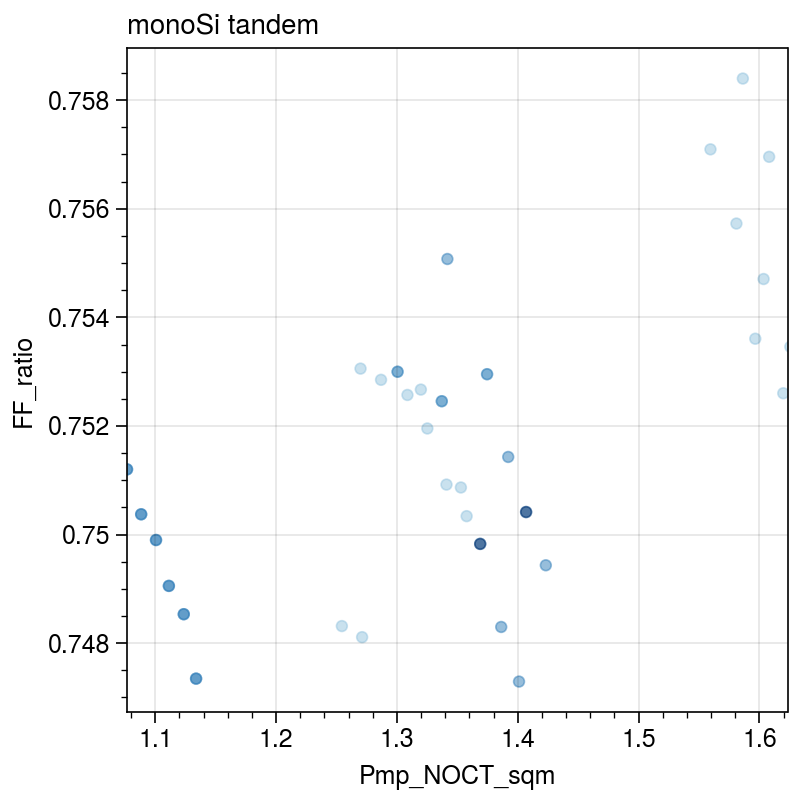

In [366]:
tandem_cell_types = new_modules_tandem['cell_type'].unique()
fig,axe = pplt.subplots(ncols=len(tandem_cell_types),
                        figsize=(4*len(tandem_cell_types),4),sharex=False, facecolor='white')

a = 0.5
ms = 15

for label, ax, color in zip(tandem_cell_types.tolist(),axe,['Blues','Greens'][0:len(tandem_cell_types)]):
    plot_data = new_modules_tandem[new_modules_tandem['cell_type']==label]
    ax.scatter(x=plot_data['Pmp_NOCT_sqm'],
            y=plot_data['FF_ratio'],
            cmap=pplt.get_colors(color,6)[2:],
            c=plot_data['year_added'],alpha=a,s=ms,label=label)
    ax.format(ltitle=label+" tandem",
              xlim=(plot_data['Pmp_NOCT_sqm'].quantile(0.05),plot_data['Pmp_NOCT_sqm'].quantile(0.95)))


### Typ Mono Tandem

#### Halfcut

In [538]:
mono_tandem = new_modules_tandem[new_modules_tandem['cell_type']=="monoSi"]

# capture individual clusters from the original plot
mono_tandem_a = mono_tandem[mono_tandem['Pmp_NOCT_sqm']<1.2]
mono_tandem_b = mono_tandem[(mono_tandem['Pmp_NOCT_sqm']>1.2) & (mono_tandem['Pmp_NOCT_sqm']<1.5)]
mono_tandem_c = mono_tandem[mono_tandem['Pmp_NOCT_sqm']>1.5]

# get band of FF ratio to pull from
data = mono_tandem_b

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# extract the device closest to the median value for power density under NOCT
num = np.median(data['Pmp_NOCT_sqm'])
result = data.iloc[(data['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]

monoSi_tandemJ_halfcut = extract_core_params(result,"monoSi_tandemJ_halfcut",'typical HJT halfcut monocrystalline module',ncols=6,nrows=20,cell_height=83,cell_width=166,col_spacing=1,row_spacing=2,frame_thickness=5)
final_devices.append(monoSi_tandemJ_halfcut)

#### Square

In [539]:
mono_tandem = new_modules_tandem[new_modules_tandem['cell_type']=="monoSi"]

# capture individual clusters from the original plot
mono_tandem_a = mono_tandem[mono_tandem['Pmp_NOCT_sqm']<1.2]
mono_tandem_b = mono_tandem[(mono_tandem['Pmp_NOCT_sqm']>1.2) & (mono_tandem['Pmp_NOCT_sqm']<1.5)]
mono_tandem_c = mono_tandem[mono_tandem['Pmp_NOCT_sqm']>1.5]

# get band of FF ratio to pull from
data = mono_tandem_c

# reduce by the 5th and 95th interval under power density under NOCT
data = data[(data['Pmp_NOCT_sqm']>data['Pmp_NOCT_sqm'].quantile(0.05)) & (data['Pmp_NOCT_sqm']<data['Pmp_NOCT_sqm'].quantile(0.95))]

# extract the device closest to the median value for power density under NOCT
num = np.median(data['Pmp_NOCT_sqm'])
result = data.iloc[(data['Pmp_NOCT_sqm'] - num).abs().argsort()[:1]]

monoSi_tandemJ_square = extract_core_params(result,"monoSi_tandemJ_square",'typical HJT square monocrystalline module',ncols=8,nrows=12,cell_height=130,cell_width=130,col_spacing=1.3,row_spacing=1.3,frame_thickness=3)
final_devices.append(monoSi_tandemJ_square)


### Collect

In [602]:
mini_module = {'name':'monoSi_singleJ_square_mini',
  'bishop_N_p_typical':1,
'bishop_N_s_typical':6,
'bishop_breakdown_exp':3.0,
'bishop_breakdown_factor':0.002,
'bishop_breakdown_voltage':-15,
'desoto_bandgap_temp_coe_dEgdT':-0.0002677,
'desoto_diode_factor_a_ref':2.339992667,
'desoto_energy_bandgap_Egref':1.121,
'desoto_photocurrent_I_L_ref':8.628778,
'desoto_saturation_current_I_o_ref':4.956246e-10,
'desoto_series_resist_R_s_ref':0.300444,
'desoto_short_circuit_temp_coe_alpha_sc':0.00003784,
'desoto_shunt_resist_R_sh_ref':89.785065,
'general_cell_area_mm2_typical':22500,
'general_cell_height_mm_typical':150,
'general_cell_type':'monoSi',
'general_cell_width_mm_typical':150,
'general_description':'a small monocrystalline module that is used for the template file',
'general_heterojunction':False,
'general_monolithic':False,
'module_n_subcell_cols_typical':1,
'module_n_subcell_rows_typical':1,
'module_shape_N_columns_typical':2,
'module_shape_N_rows_typical':3,
'module_shape_area_m2':None,
'module_shape_column_spacing_mm':2.5,
'module_shape_flex':False,
'module_shape_frame_thickness_mm':15,
'module_shape_height_mm':None,
'module_shape_row_spacing_mm':2.5,
'module_shape_width_mm':None,	
'performance_NOCT_T_degC':45.4,
'performance_cell_efficiency_ref':None,
'performance_module_efficiency_ref':None,
'performance_power_W_ref':None,
'performance_temp_coe_gamma_pctC':-0.00485,
'performance_thermal_resilience':0,
'general_device_id':None}

width, height, area = calc_module_dimensions(mini_module['general_cell_width_mm_typical'], 
                       mini_module['module_shape_N_columns_typical'], 
                       mini_module['module_shape_column_spacing_mm'], 
                       mini_module['general_cell_height_mm_typical'], 
                       mini_module['module_shape_N_rows_typical'], 
                       mini_module['module_shape_row_spacing_mm'], 
                       mini_module['module_shape_frame_thickness_mm'])
mini_module['module_shape_width_mm'] = width
mini_module['module_shape_height_mm'] = height
mini_module['module_shape_area_m2'] = area

mini_module['performance_power_W_ref'], mini_module['performance_cell_efficiency_ref'], mini_module['performance_module_efficiency_ref'] = calc_efficiency(mini_module)

mini_module = pd.Series(mini_module).rename(mini_module['name'])
mini_module.drop('name',inplace=True)



In [603]:
typical_devices = pd.concat(final_devices[0:8]+[mini_module],axis=1).transpose()
typical_devices['general_device_id'] = ["D"+str(n+1).zfill(3) for n in range(0,len(typical_devices))]

str_cols = ['general_cell_type', 'general_description', 'general_monolithic', 'general_heterojunction', 'module_shape_flex', 'general_device_id']
for col in typical_devices.columns:
    if col in str_cols:
        typical_devices[col] = typical_devices[col].astype(str)
    else:
        typical_devices[col] = typical_devices[col].astype(float)

typical_devices.to_csv("/Users/jmccarty/Desktop/cactus_typical_devices.csv")

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

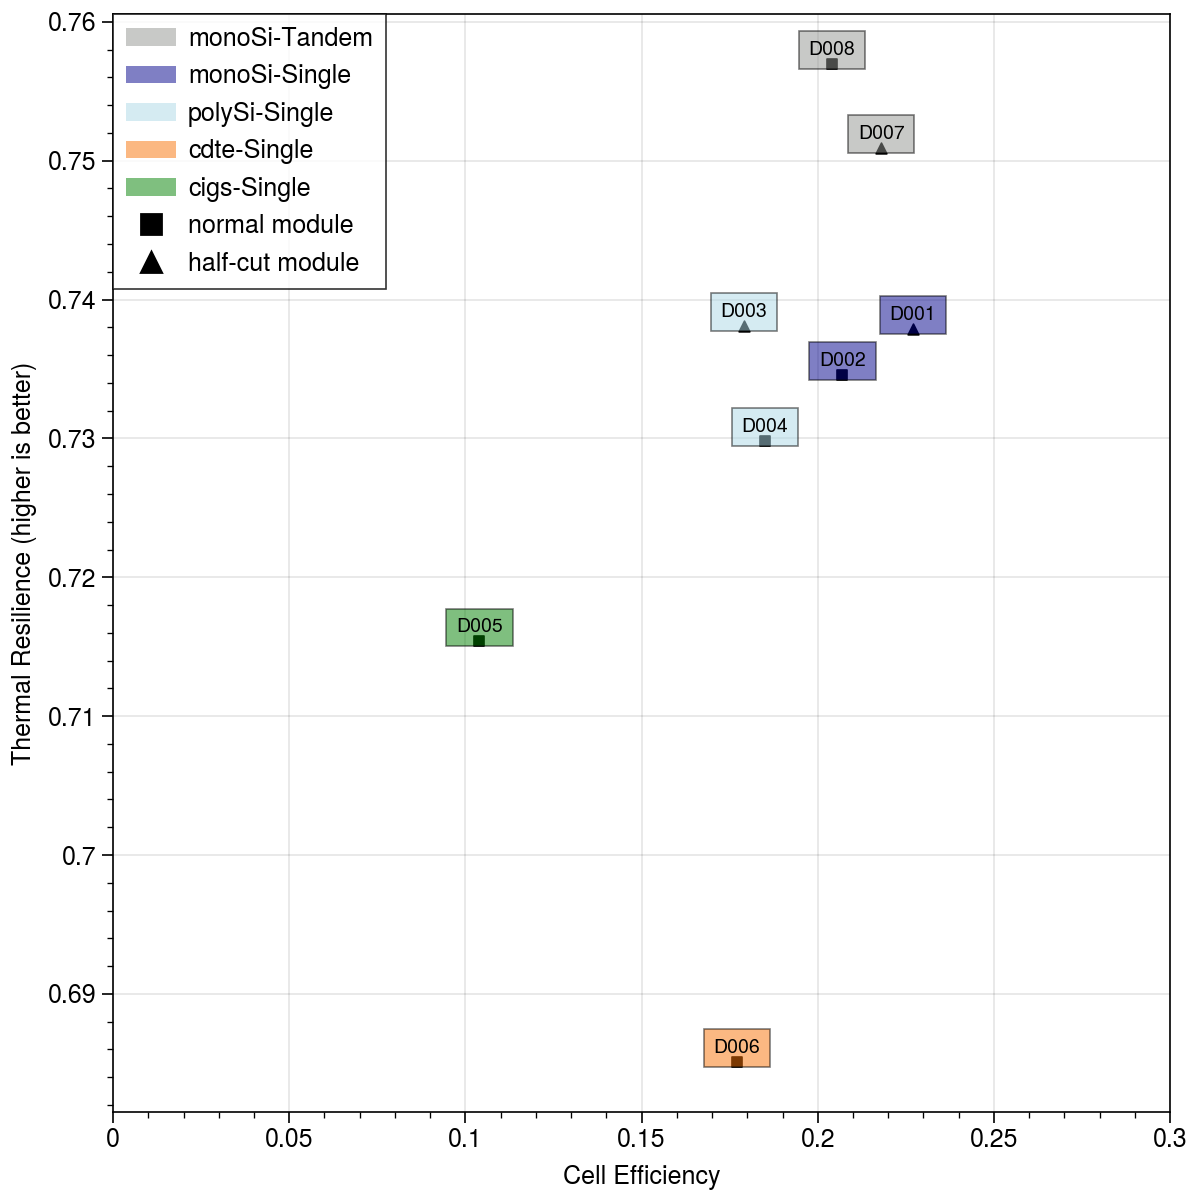

In [562]:
fig, axe = pplt.subplots(ncols=1, nrows=1, figsize=(6, 6), facecolor="white")

ax = axe[0]

#markersize
ms = 15

# square
plot_square = typical_devices[typical_devices['bishop_N_p_typical']==1]
ax.scatter(
    x=plot_square["performance_cell_efficiency_ref"],
    y=plot_square["performance_thermal_resilience"],
    marker="s",
    s=ms,
    c="k",
)

# half cut
plot_halfcut = typical_devices[typical_devices['bishop_N_p_typical']>1]
ax.scatter(
    x=plot_halfcut["performance_cell_efficiency_ref"],
    y=plot_halfcut["performance_thermal_resilience"],
    marker="^",
    s=ms,
    c="k",
)

color_map = {
    "monoSiTrue": "grey",
    "monoSiFalse": "darkblue",
    "polySiFalse": "lightblue",
    "cdteFalse": "orange",
    "cigsFalse": "green",
}


for idx, row in typical_devices.iterrows():
    ax.text(
        x=row["performance_cell_efficiency_ref"],
        y=row["performance_thermal_resilience"] + 0.001,
        s=row["general_device_id"],
        horizontalalignment="center",
        verticalalignment="center",
        bbox=True,
        bboxcolor=color_map[row["general_cell_type"] + row["general_heterojunction"]],
        bboxalpha=0.5,
        bboxstyle="square",
        fontsize=7,
    )

legend_el = []
for k, v in color_map.items():
        if "True" in k:
                k = k.replace("True", "-Tandem")
        else:
                k = k.replace("False", "-Single")
        p = Patch(facecolor=v, edgecolor=None, label=k, alpha=0.5)
        legend_el.append(p)
        
square_leg_el = Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=ms/2, label='normal module')
legend_el.append(square_leg_el)

half_cut_leg_el = Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=ms/2, label='half-cut module')
legend_el.append(half_cut_leg_el)

ax.legend(legend_el, ncols=1, loc="ul")

ax.format(
    xlim=(0, 0.3),
    #   xlim=(0,0.3),
    xlabel="Cell Efficiency",
    ylabel="Thermal Resilience (higher is better)",
)

# Cluster on Params

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

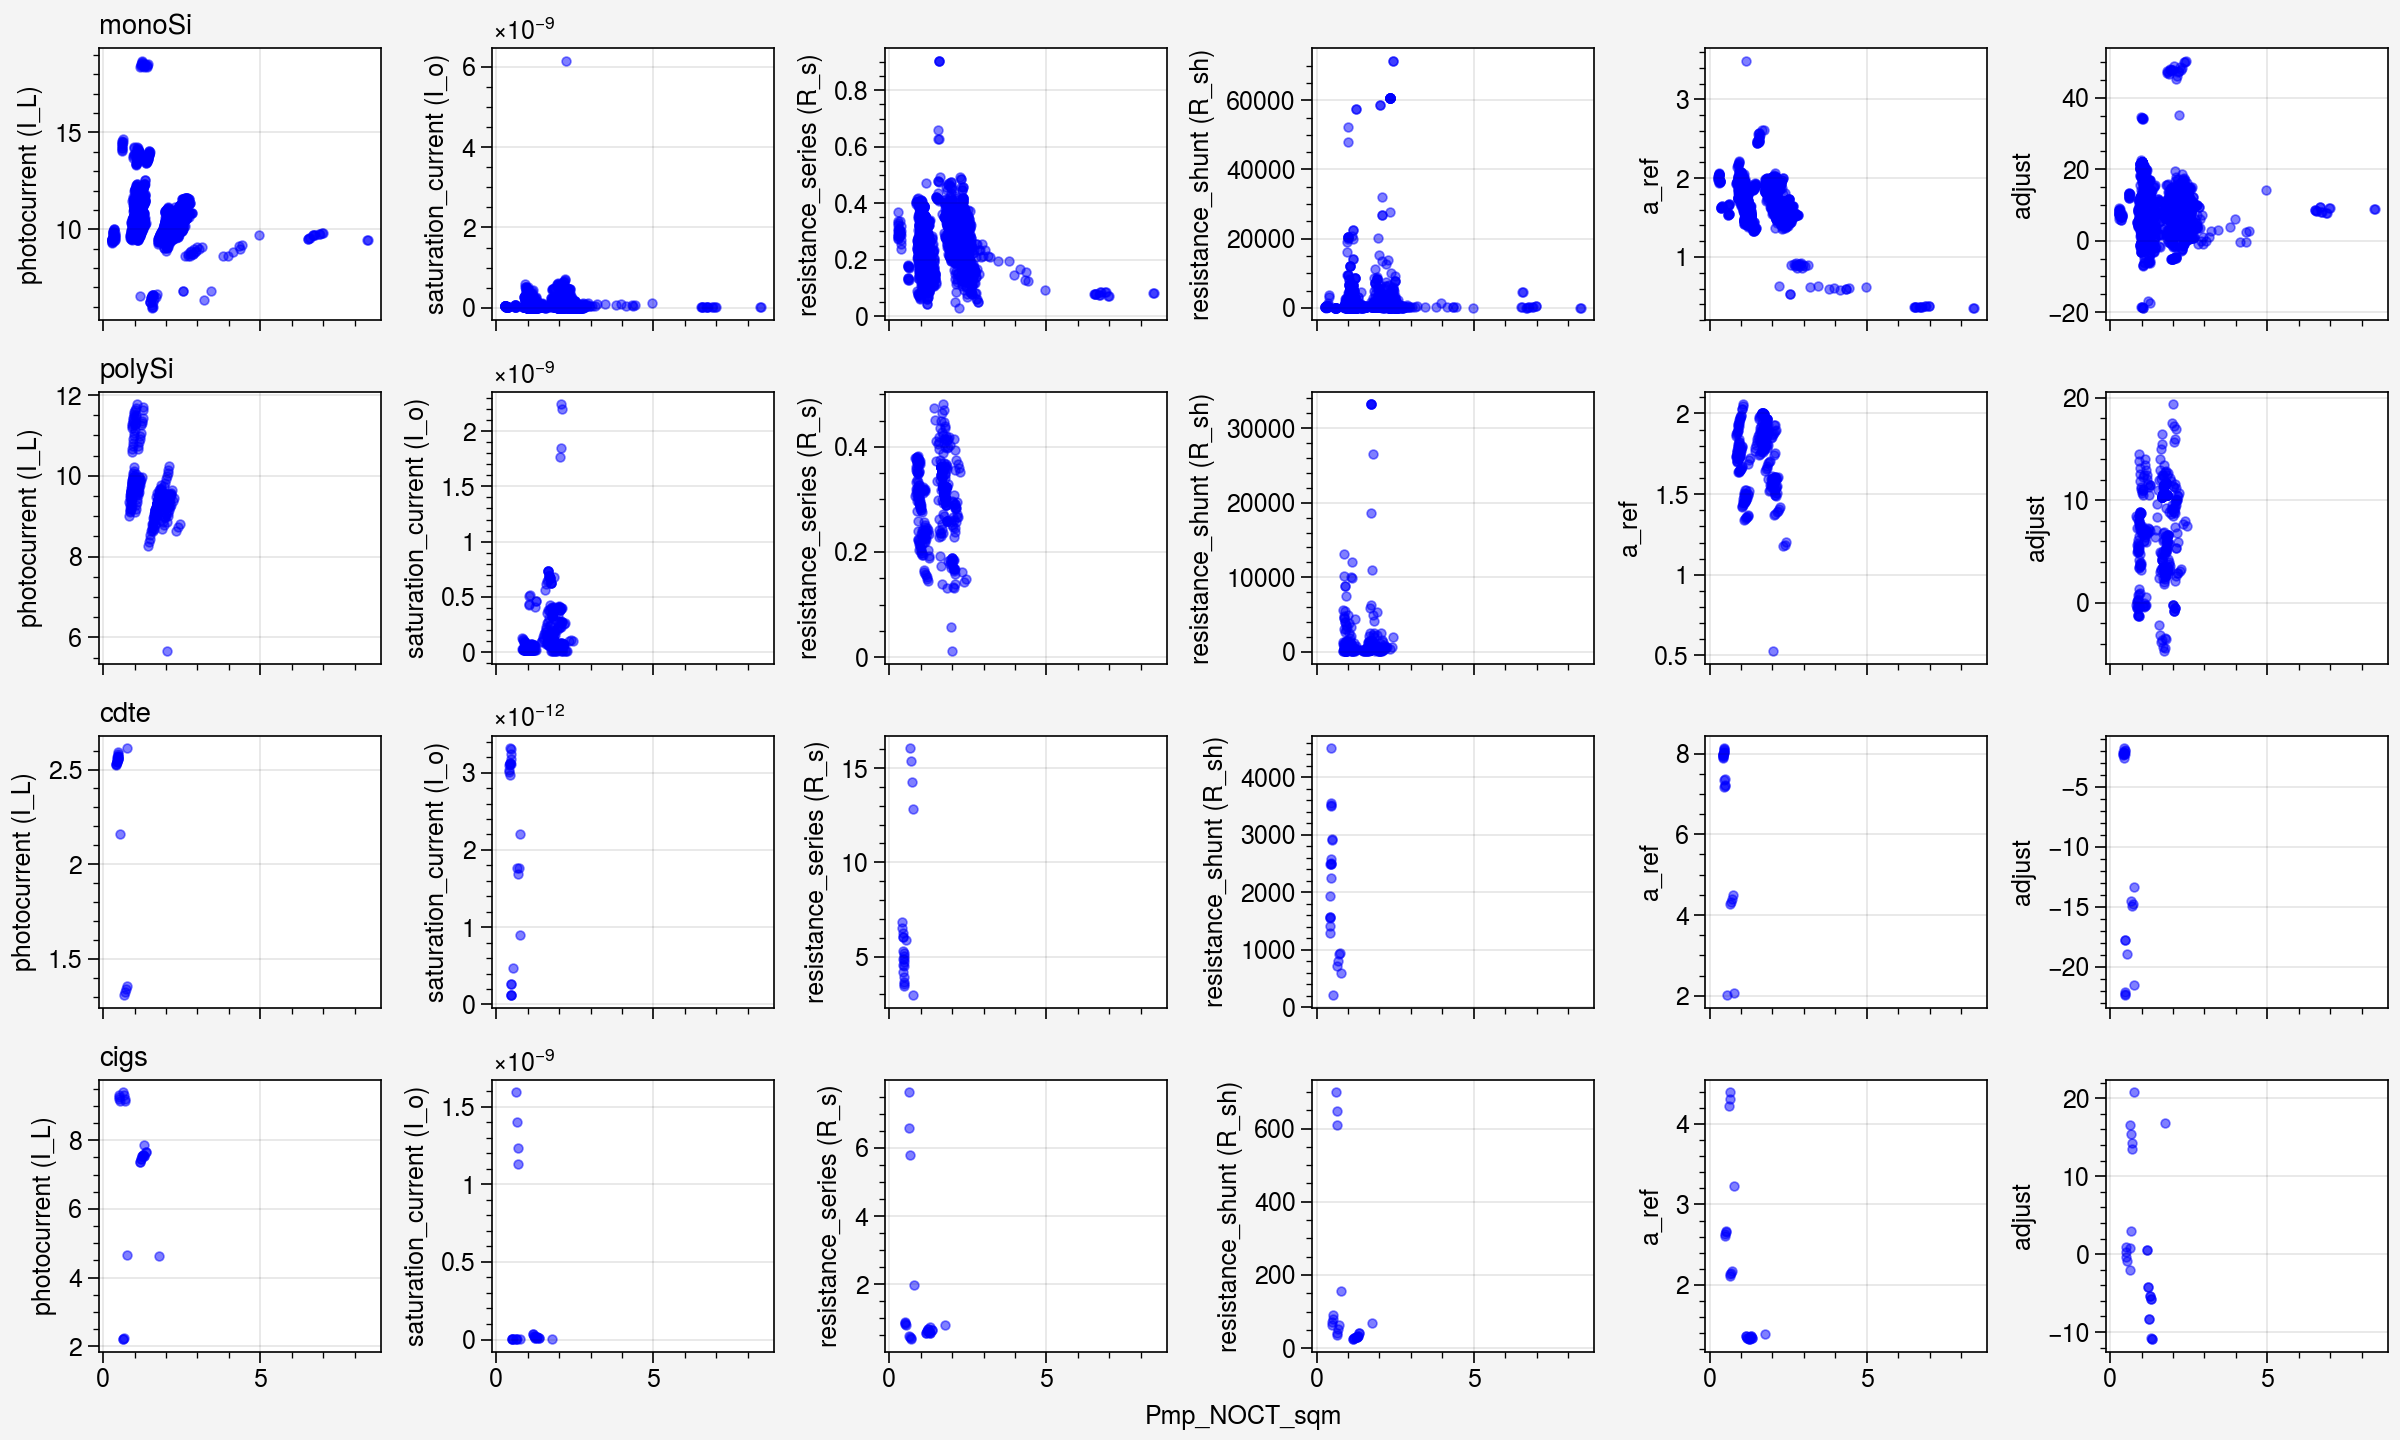

In [874]:
param_cols = [
    "photocurrent (I_L)",
    "saturation_current (I_o)",
    "resistance_series (R_s)",
    "resistance_shunt (R_sh)",
    "a_ref",
    "adjust",
]

cell_types = ["monoSi", "polySi", "cdte", "cigs"]

fig, axe = pplt.subplots(
    nrows=len(cell_types),
    ncols=len(param_cols),
    figsize=(len(param_cols) * 2, len(cell_types) * 1.8),
    sharey=False,
)


for r, cell_type in enumerate(cell_types):
       df = new_modules[new_modules["cell_type"] == cell_type][
              param_cols + ["Pmp_NOCT_sqm"]
       ]

       for n, col in enumerate(param_cols):
              ax = axe[r, n]
              ax.scatter(x=df["Pmp_NOCT_sqm"], y=df[col], c="blue", alpha=0.5, s=ms)
       axe[r,0].format(ltitle=cell_type)


/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

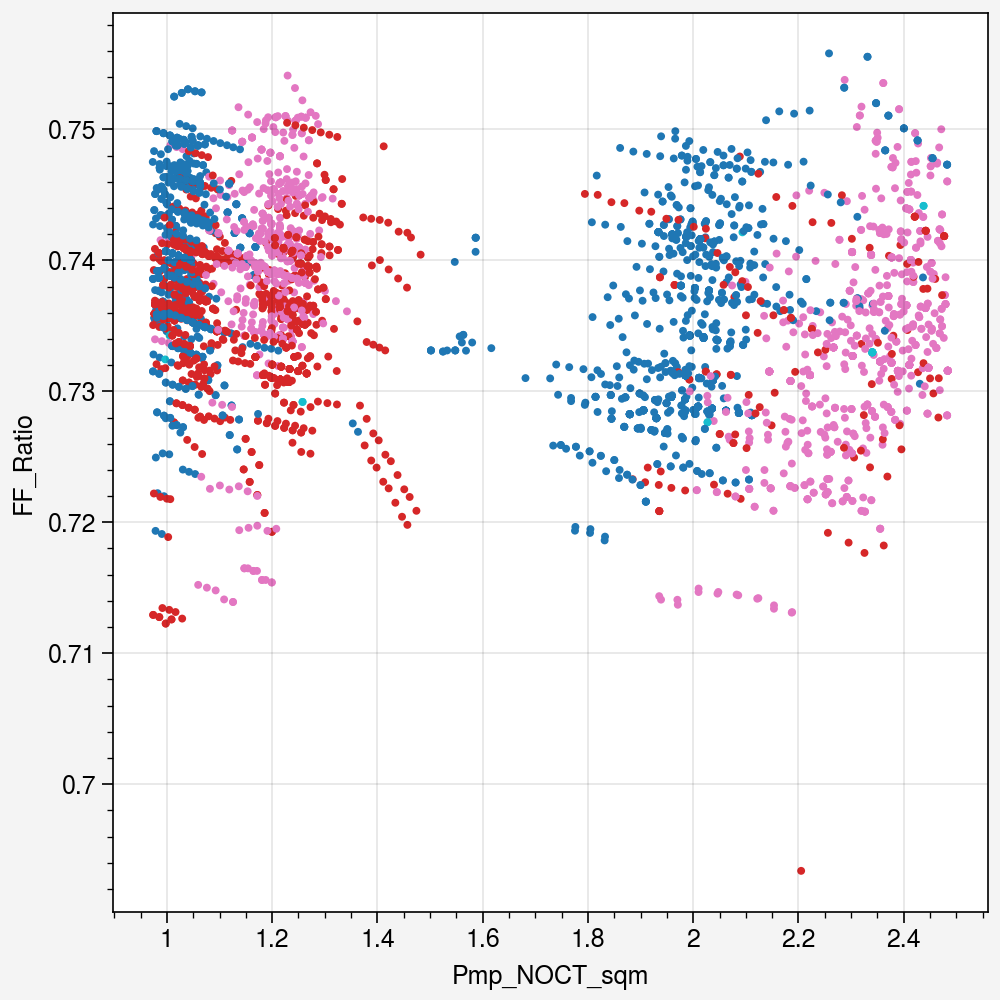

In [967]:
cell_type = 'monoSi'
device = new_modules[new_modules['cell_type']==cell_type]
lower_bound = device['Pmp_NOCT_sqm'].quantile(0.05)
upper_bound = device['Pmp_NOCT_sqm'].quantile(0.95)

mask = (device['Pmp_NOCT_sqm']>=lower_bound) & (device['Pmp_NOCT_sqm']<=upper_bound)
cluster_data = device[mask][param_cols]
scaler = MinMaxScaler()
cluster_data_std = scaler.fit_transform(cluster_data)


reduced_data = PCA(n_components=6).fit_transform(cluster_data_std)
# kmeans = KMeans(n_clusters=4, n_init=4, random_state=42)
# kmeans.fit(cluster_data_std)

cluster.DBSCAN()

fig,axe = pplt.subplots(figsize=(5,5))
axe[0].scatter(x=device[mask]['Pmp_NOCT_sqm'],y=device[mask]['FF_Ratio'],c=kmeans.labels_,s=5,cmap='tab10')
# axe[0].format(ylim=(-1,1))

In [911]:
kmeans.cluster_centers_

AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

# Distribution Plots

Text(0.5, 0.98, 'Peak Power by Number in Series')

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

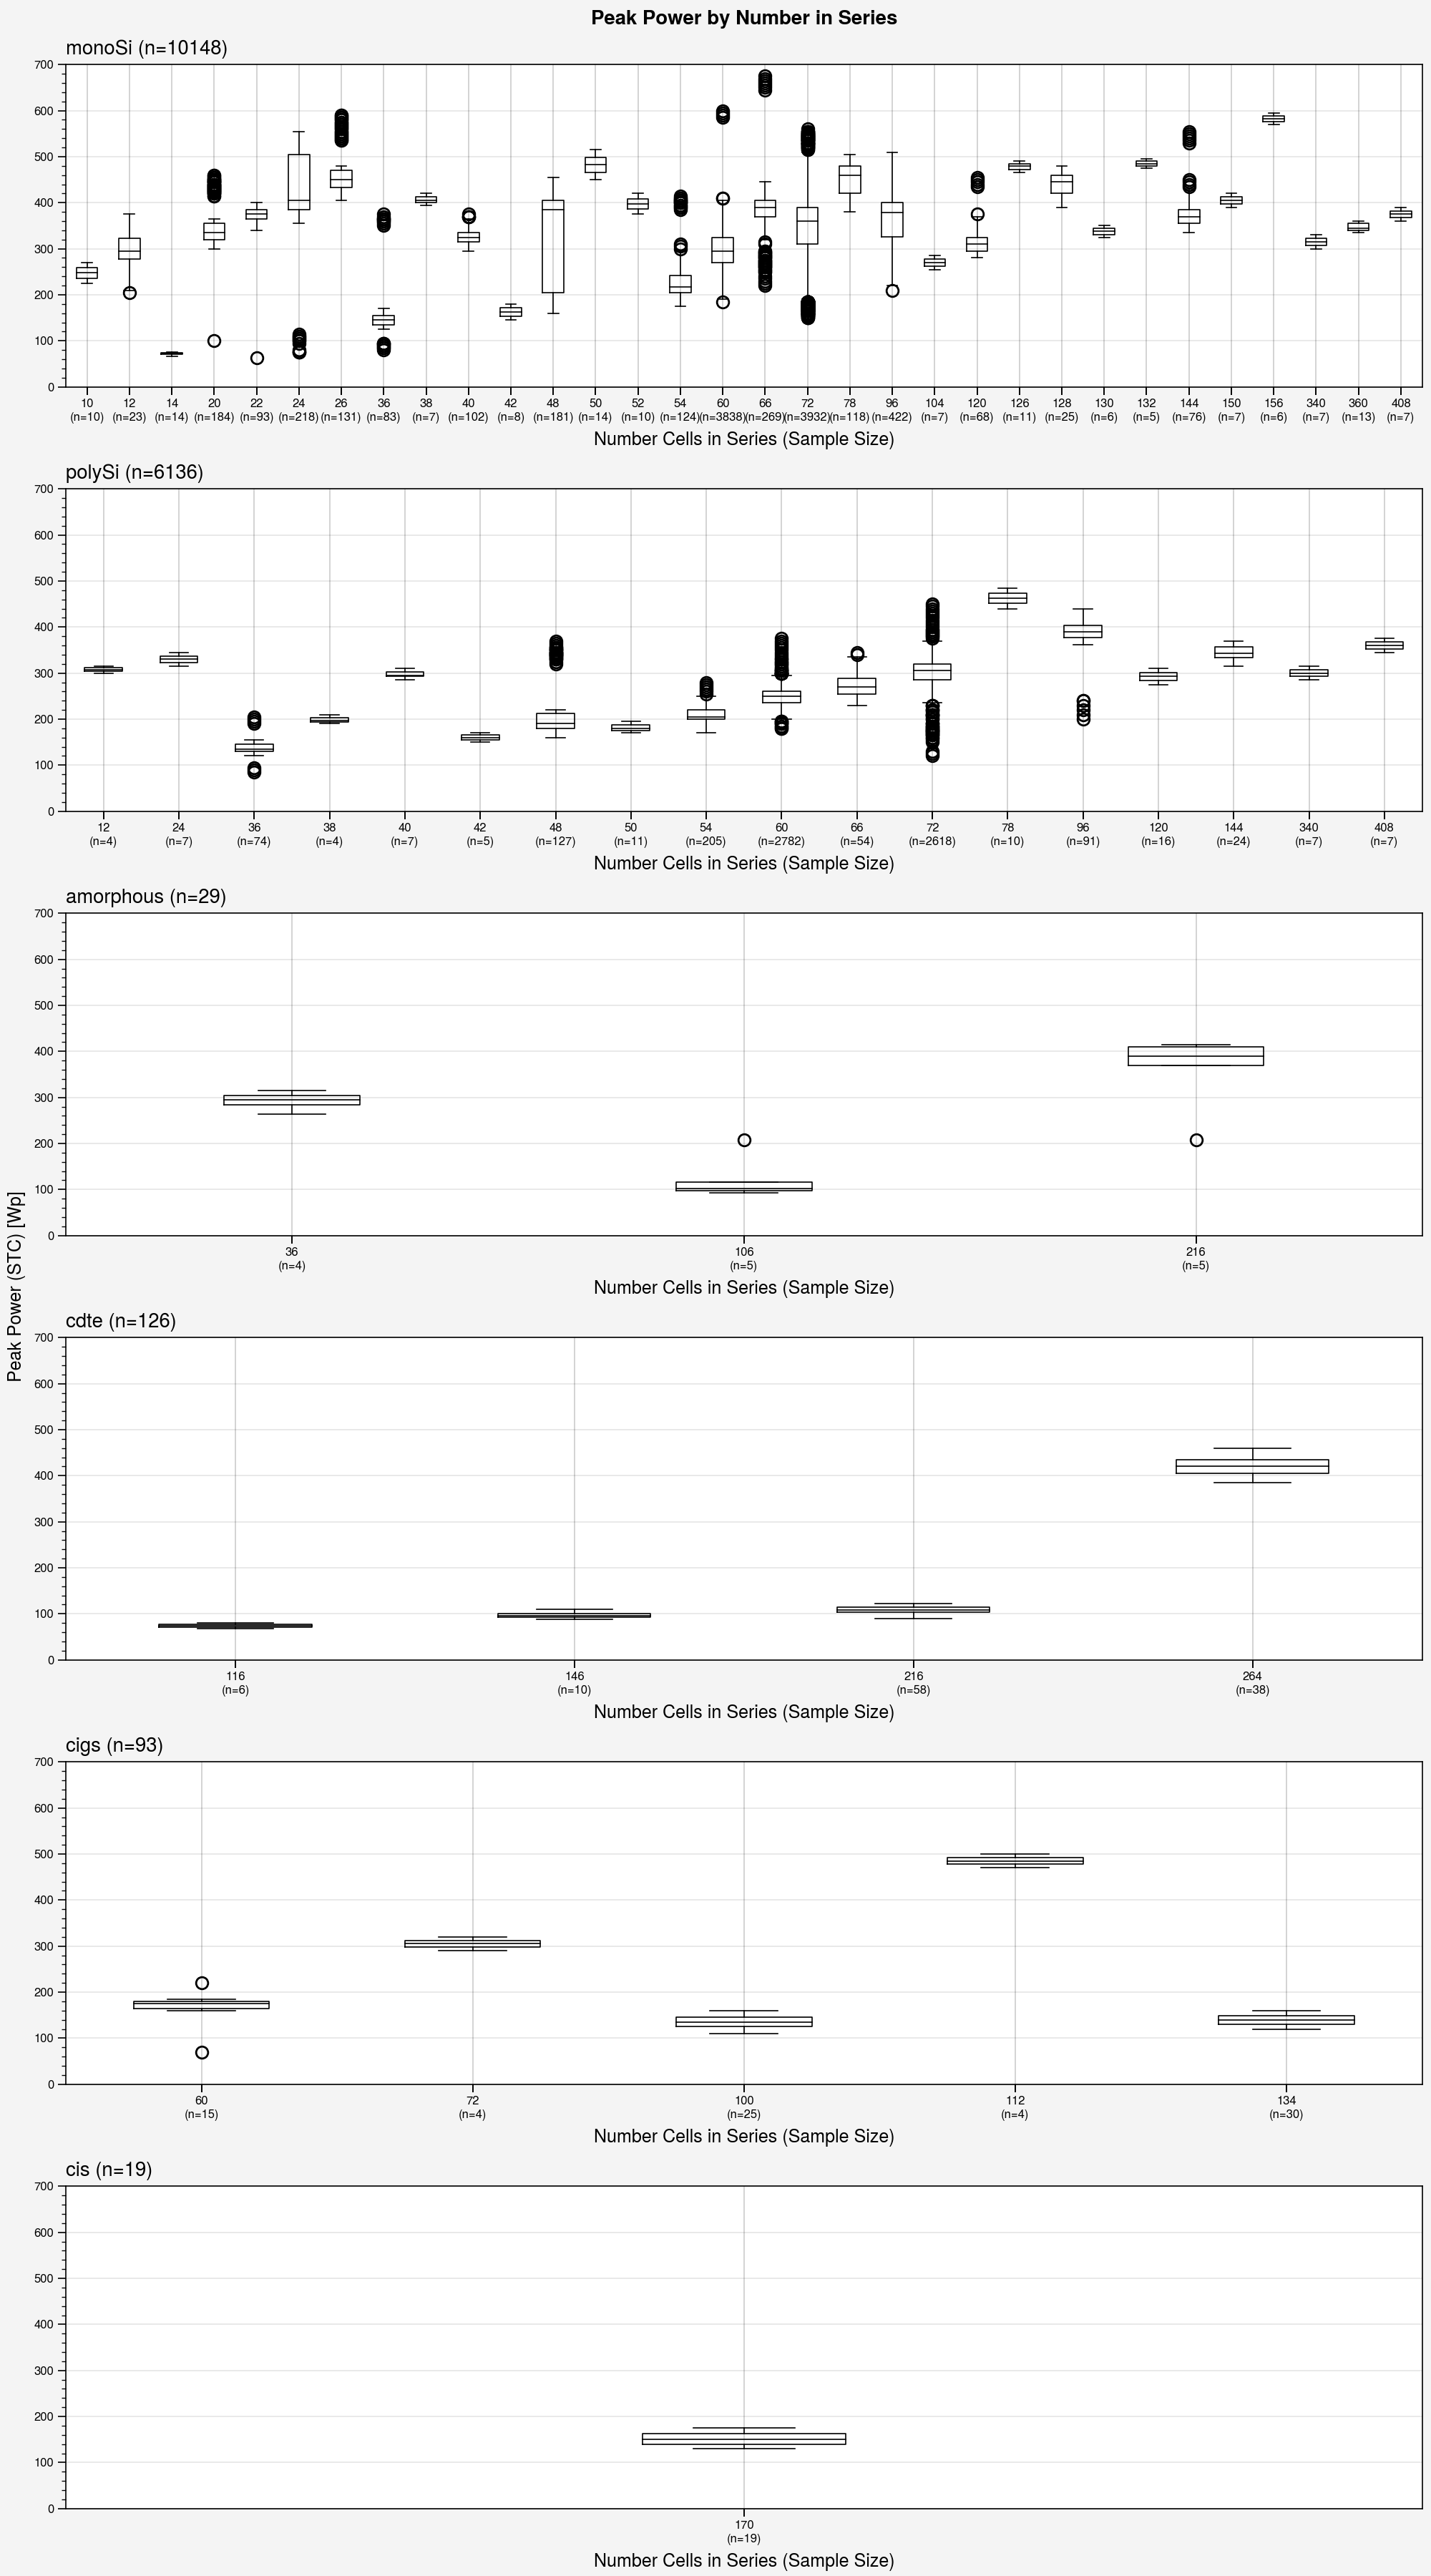

In [344]:
unique_tech_list = single_device['cell_type'].unique()
n_tech = len(unique_tech_list)

fig, axe = pplt.subplots(figsize=(10,3*n_tech), nrows=n_tech, sharey=True, sharex=False)

for n,cell_type in enumerate(unique_tech_list):
    cell_df = single_device[single_device['cell_type']==cell_type]

    unique_Ns_list = cell_df['N_s'].astype(int).unique()
    unique_Ns_list.sort()
    
    plot_data = {}
    for unique_Ns in unique_Ns_list:
        if len(cell_df[cell_df['N_s']==unique_Ns])<4:
            pass
        elif (unique_Ns % 2) != 0:
            pass
        else:
        
            plot_data[f"{unique_Ns}\n(n={len(cell_df[cell_df['N_s']==unique_Ns])})"] = cell_df[cell_df['N_s']==unique_Ns]['nameplate Pmax [W]'].astype(float).tolist()

    ax = axe[n]

    ax.box(pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in plot_data.items() ])))

    ax.format(xlabel='Number Cells in Series (Sample Size)',
            ylabel='Peak Power (STC) [Wp]',
            ylim=(0,round(single_device['nameplate Pmax [W]'].astype(float).max(),-2)),
            ltitle=f"{cell_type} (n={len(cell_df)})",
            xticklabelsize=6,
            yticklabelsize=6)
    
fig.suptitle("Peak Power by Number in Series")

Text(0.5, 0.98, 'Power Density by Number in Series')

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

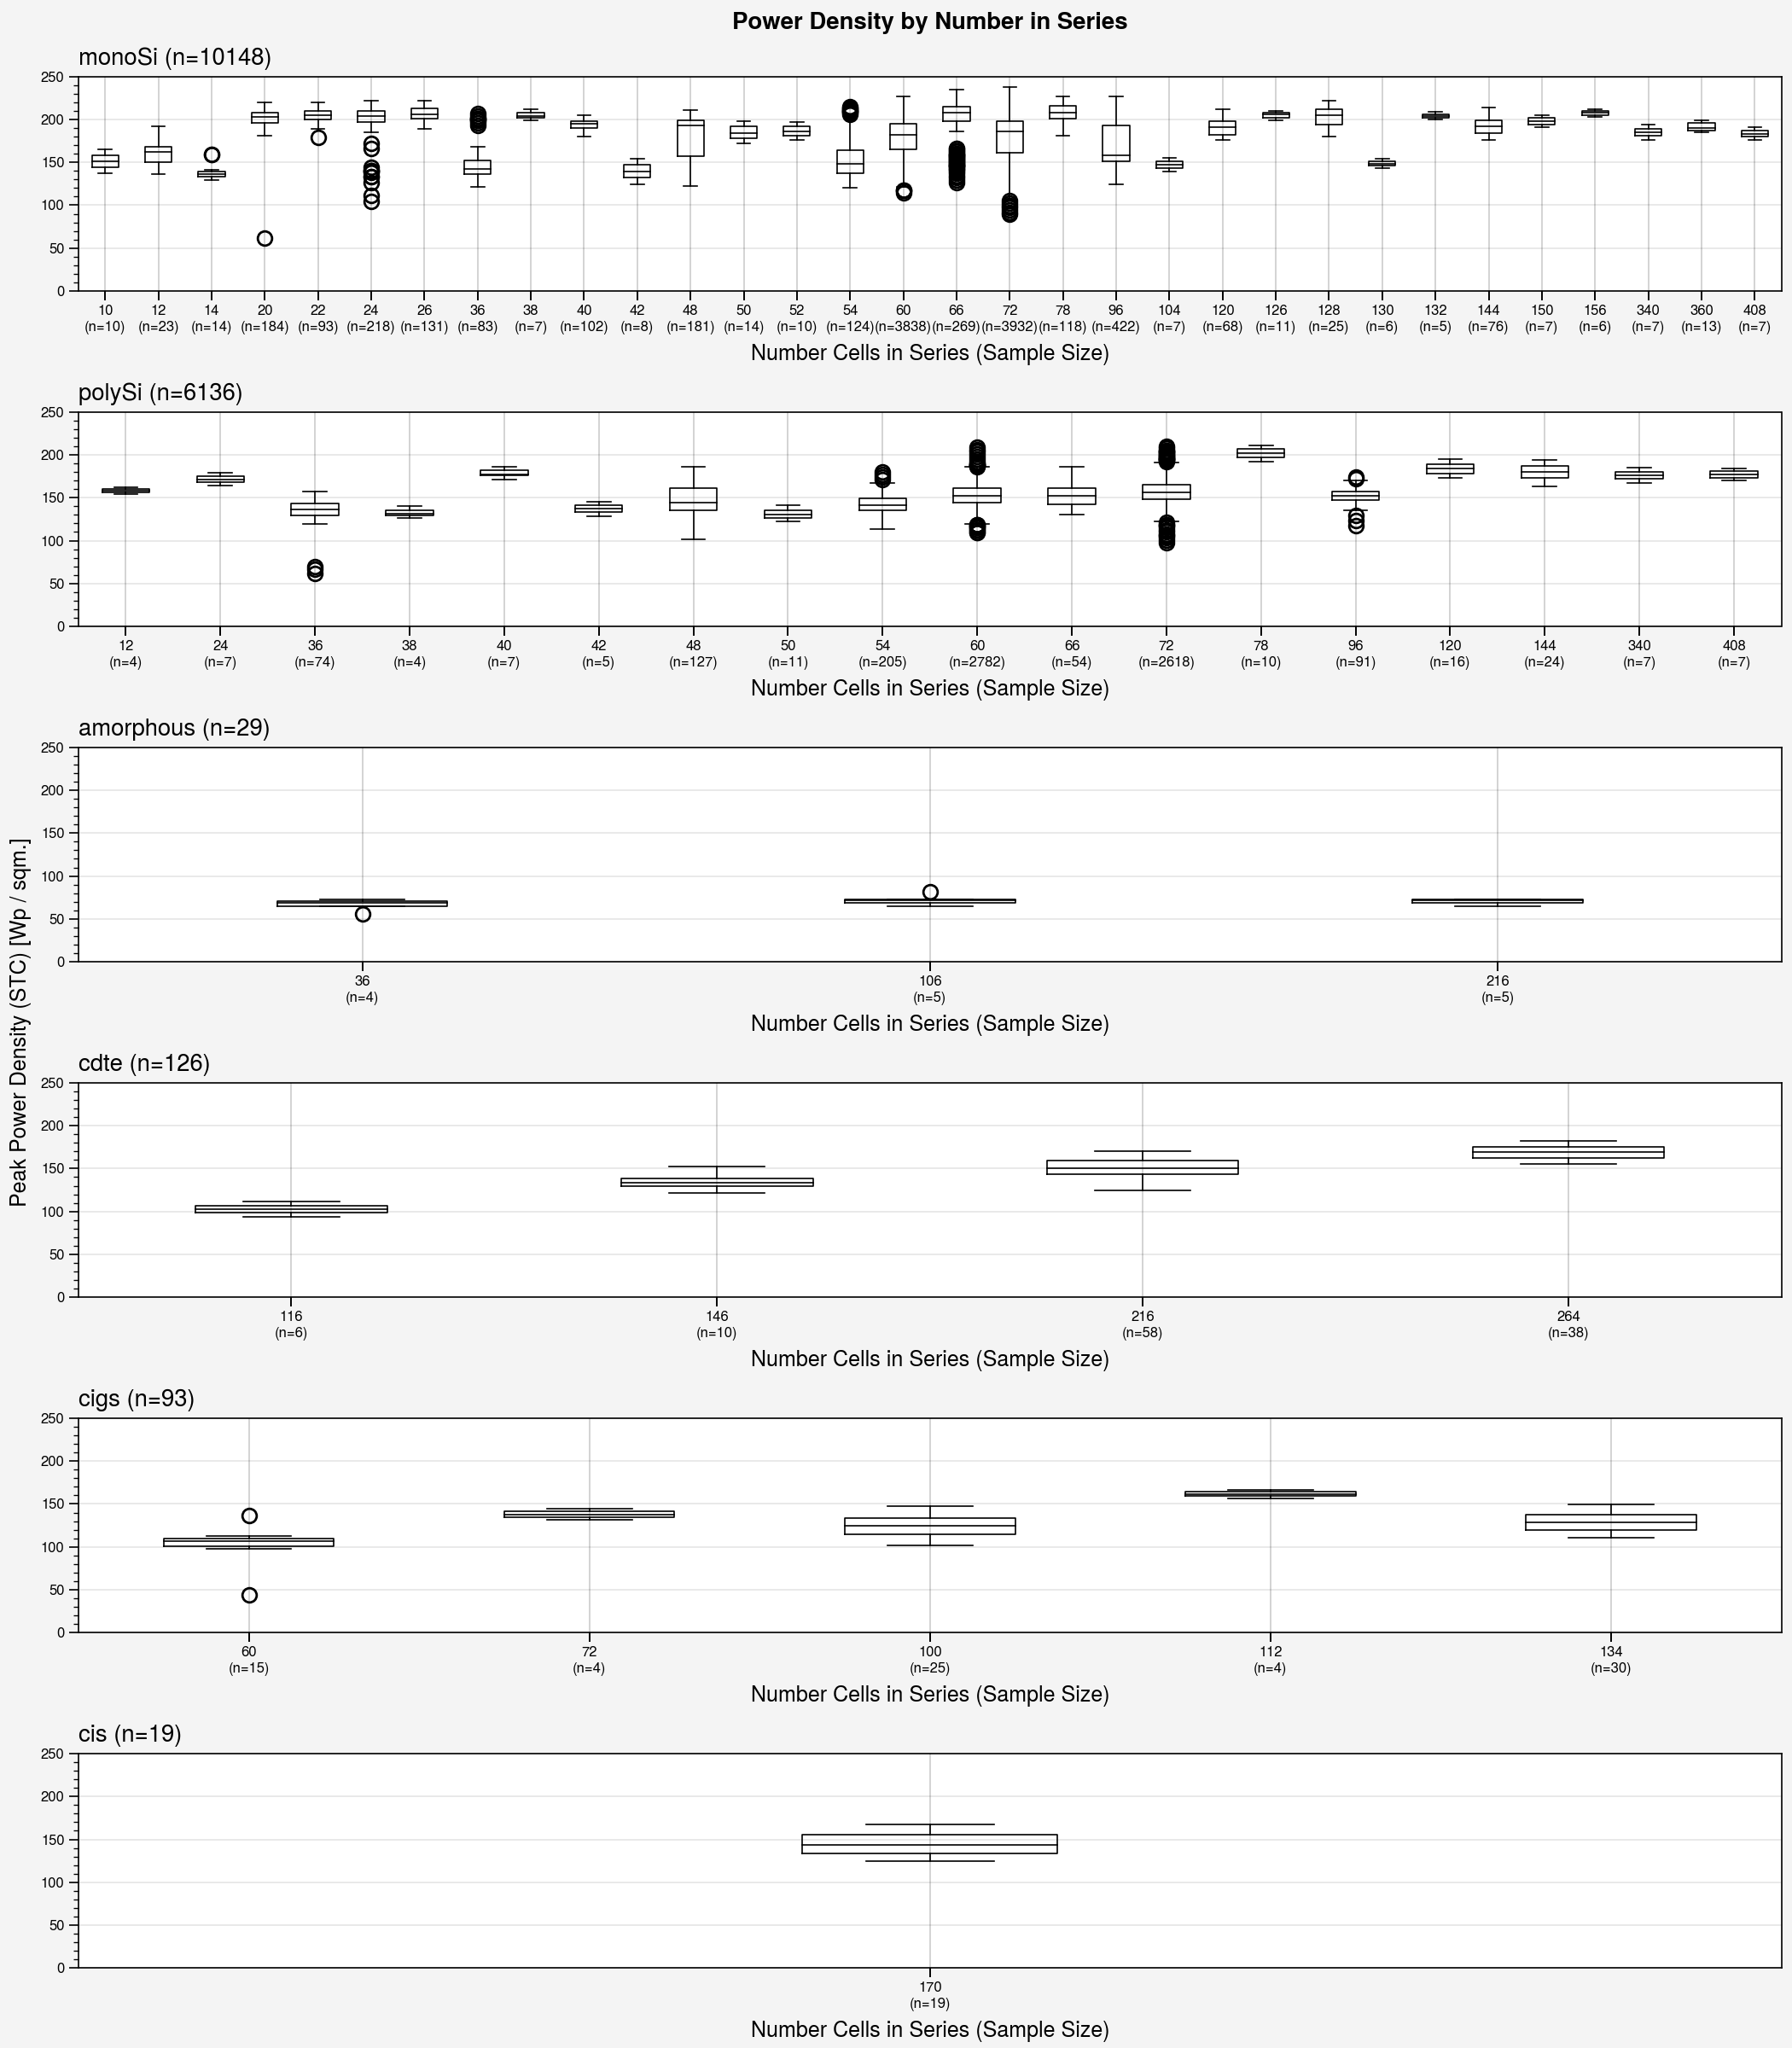

In [352]:
unique_tech_list = single_device['cell_type'].unique()
n_tech = len(unique_tech_list)

fig, axe = pplt.subplots(figsize=(10.5,2*n_tech), nrows=n_tech, sharey=True, sharex=False)

for n,cell_type in enumerate(unique_tech_list):
    cell_df = single_device[single_device['cell_type']==cell_type]

    unique_Ns_list = cell_df['N_s'].astype(int).unique()
    unique_Ns_list.sort()
    
    plot_data = {}
    for unique_Ns in unique_Ns_list:
        if len(cell_df[cell_df['N_s']==unique_Ns])<4:
            pass
        elif (unique_Ns % 2) != 0:
            pass
        else:
            value = cell_df[cell_df['N_s']==unique_Ns]['nameplate Pmax [W]'].astype(float) / cell_df[cell_df['N_s']==unique_Ns]['area [m2]'].astype(float)
            plot_data[f"{unique_Ns}\n(n={len(cell_df[cell_df['N_s']==unique_Ns])})"] = value.tolist()

    ax = axe[n]

    ax.box(pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in plot_data.items() ])))

    ax.format(xlabel='Number Cells in Series (Sample Size)',
            ylabel='Peak Power Density (STC) [Wp / sqm.]',
            ylim=(0,250),
            ltitle=f"{cell_type} (n={len(cell_df)})",
            xticklabelsize=6,
            yticklabelsize=6)
    
fig.suptitle("Power Density by Number in Series")

# Scratch

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

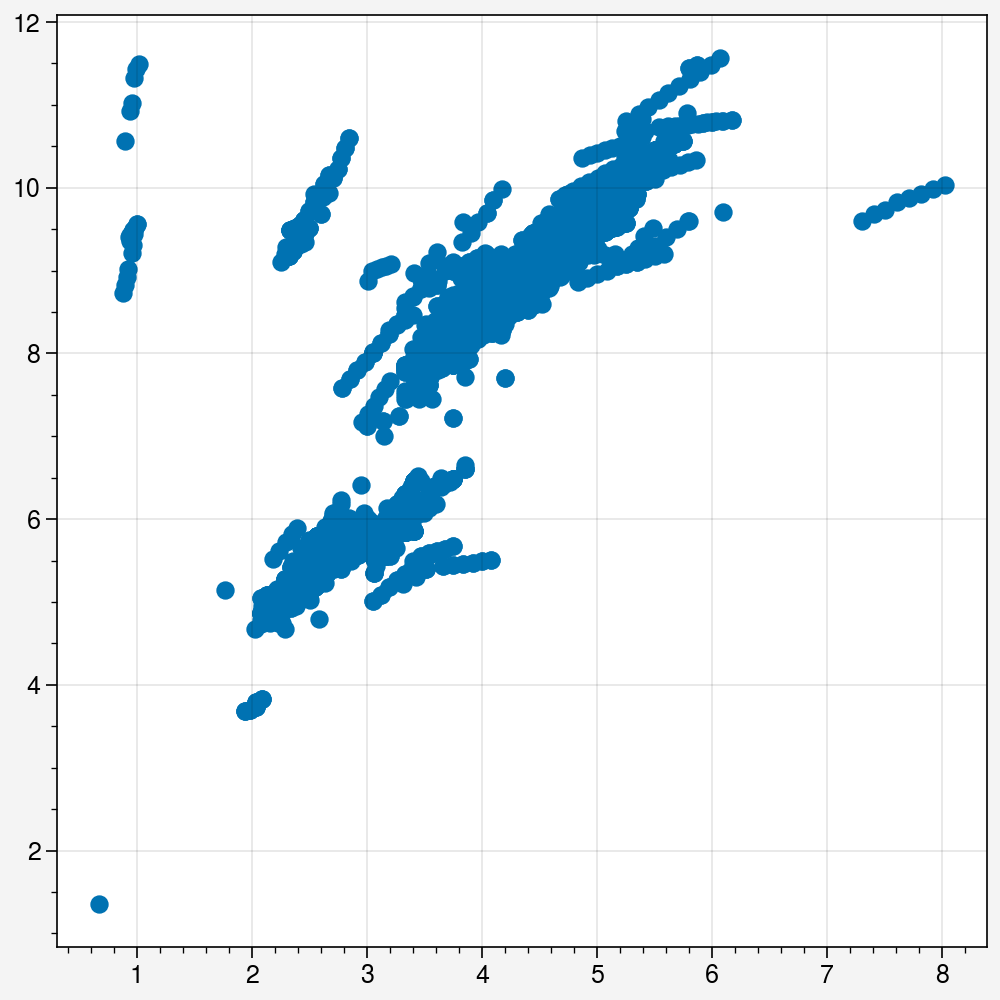

In [130]:
mono_df = cec_df[cec_df['Technology']=='Mono-c-Si']

fig, axe = pplt.subplots(figsize=(5,5))

ax = axe[0]

ax.scatter(x=mono_df['STC'].astype(float).values / mono_df['N_s'].astype(int).values,
           y=mono_df['I_sc_ref'].astype(float).values) 



In [28]:
mono_df[mono_df['N_s'].astype(int)>300]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Seraphim_Energy_Group_Inc__SEG_E01B_300,Mono-c-Si,0,300.108,274.4,1.7,NaN,NaN,340,8.73,43.85,...,1.880767,9.198568,6.631008e-10,0.322398,127.226227,27.282461,-0.437,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01B_305,Mono-c-Si,0,305.016,279.1,1.7,NaN,NaN,340,8.83,44.1,...,1.864512,9.007972,4.810815e-10,0.333463,6141.729004,24.040182,-0.437,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01B_310,Mono-c-Si,0,310.32,283.8,1.7,NaN,NaN,340,8.92,44.35,...,1.901203,9.398229,6.698166e-10,0.320056,129.228256,27.160631,-0.437,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01B_315,Mono-c-Si,0,315.302,288.5,1.7,NaN,NaN,340,9.02,44.6,...,1.912675,9.504216,6.829696e-10,0.318578,125.291298,27.249557,-0.437,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01B_325,Mono-c-Si,0,325.008,298.0,1.7,NaN,NaN,340,9.21,45.1,...,1.935643,9.705688,7.090081e-10,0.316057,118.184738,27.42732,-0.437,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01B_330,Mono-c-Si,0,330.096,302.7,1.7,NaN,NaN,340,9.31,45.3,...,1.926754,9.60203,5.819879e-10,0.317347,306.644012,25.392052,-0.437,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01A_365,Mono-c-Si,0,365.16,332.4,2.04,NaN,NaN,408,10.56,43.9,...,1.913514,11.004962,1.167927e-09,0.244786,166.211823,31.305563,-0.459,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01A_385,Mono-c-Si,0,385.032,351.2,2.04,NaN,NaN,408,10.93,44.7,...,1.946845,11.271767,1.183904e-09,0.227307,242.017197,31.154665,-0.459,N,SAM 2018.11.11 r2,1/3/2019
Seraphim_Energy_Group_Inc__SEG_E01A_390,Mono-c-Si,0,390.08,355.9,2.04,NaN,NaN,408,11.02,44.9,...,1.947623,11.244535,1.088308e-09,0.225844,836.969482,30.225452,-0.459,N,SAM 2018.11.11 r2,1/3/2019
Solaria_Corporation_Solaria_PowerXT_320R_PX,Mono-c-Si,0,320.008,293.1,1.66,NaN,NaN,340,9.41,44.0,...,1.684649,9.420384,4.203158e-11,0.30082,272.584534,5.399221,-0.382,N,SAM 2018.11.11 r2,1/3/2019


/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

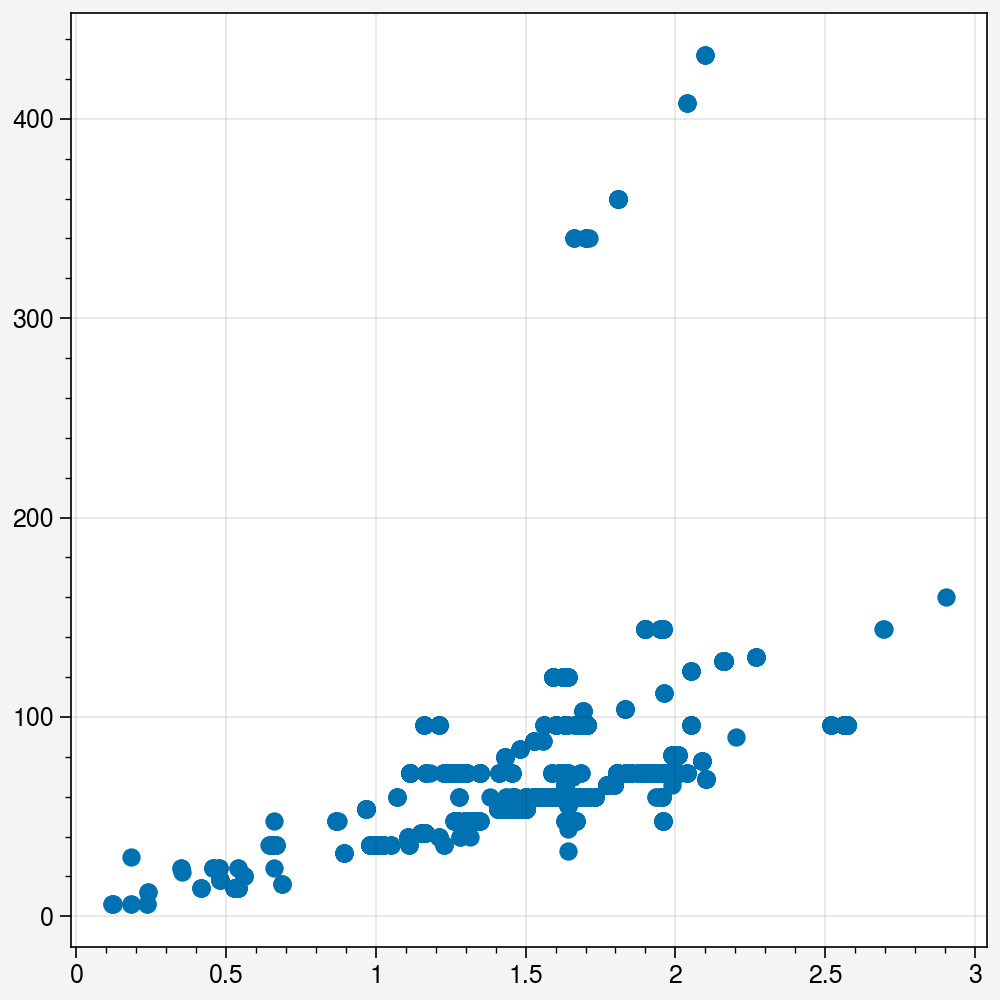

In [26]:
mono_df = cec_df[cec_df['Technology']=='Mono-c-Si']

fig, axe = pplt.subplots(figsize=(5,5))

ax = axe[0]

ax.scatter(x=mono_df['A_c'].astype(float).values,
           y= mono_df['N_s'].astype(int).values) 



In [29]:
import pvlib

In [33]:
pvlib.pvsystem.retrieve_sam(name="CECMod")

,A10Green_Technology_A10J_S72_175,A10Green_Technology_A10J_S72_180,A10Green_Technology_A10J_S72_185,A10Green_Technology_A10J_M60_220,A10Green_Technology_A10J_M60_225,A10Green_Technology_A10J_M60_230,A10Green_Technology_A10J_M60_235,A10Green_Technology_A10J_M60_240,A2Peak_Power_POWER_ON_P220_6x10,Aavid_Solar_ASMS_165P,...,Zytech_Solar_ZT275P,Zytech_Solar_ZT280P,Zytech_Solar_ZT285P,Zytech_Solar_ZT290P,Zytech_Solar_ZT295P,Zytech_Solar_ZT300P,Zytech_Solar_ZT305P,Zytech_Solar_ZT310P,Zytech_Solar_ZT315P,Zytech_Solar_ZT320P
Technology,Mono-c-Si,Mono-c-Si,Mono-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,...,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si
Bifacial,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
STC,175.0914,179.928,184.7016,219.876,224.9856,230.1288,235.008,240.5376,219.978,164.85,...,275.0144,280.3294,285.326,290.0358,295.0656,300.0032,305.0564,310.1436,315.0936,320.42
PTC,151.2,155.7,160.2,189.1,193.5,204.1,208.7,213.3,195.0,146.3,...,248.0,252.6,257.3,261.9,266.5,271.2,275.8,280.5,285.1,289.8
A_c,1.3,1.3,1.3,1.624,1.624,1.624,1.624,1.624,1.633,1.301,...,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931
Length,1.576,1.576,1.576,1.632,1.632,1.632,1.632,1.632,1.633,1.575,...,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95
Width,0.825,0.825,0.825,0.995,0.995,0.995,0.995,0.995,1.0,0.826,...,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
N_s,72,72,72,60,60,60,60,60,60,72,...,72,72,72,72,72,72,72,72,72,72
I_sc_ref,5.17,5.31,5.43,7.95,8.04,8.1,8.23,8.32,7.98,5.25,...,8.31,8.4,8.48,8.55,8.64,8.71,8.87,8.9,9.01,9.12
V_oc_ref,43.99,44.06,44.14,36.06,36.24,36.42,36.72,36.84,36.72,43.5,...,45.1,45.25,45.43,45.59,45.75,45.96,46.12,46.28,46.44,46.6


In [48]:
pv_families = cec_full['Family'].unique()

for family in pv_families:
    print(family)
    sub_df = cec_full[cec_full['Family']==family]
    for tech in sub_df['Technology'].unique():
        print(f"   - {tech}")
    

Monocrystalline
   - Mono-c-Si
   - Multi-c-Si
Polycrystalline
   - Multi-c-Si
   - Mono-c-Si
   - Thin Film
Thin Film
   - Thin Film
   - CdTe
   - CIGS
   - Multi-c-Si
 Polycrystalline 
   - Multi-c-Si
CIGS Thin Film
   - Thin Film
HIT-Si Thin Film
   - Multi-c-Si
polycrystalline
   - Multi-c-Si


/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/s

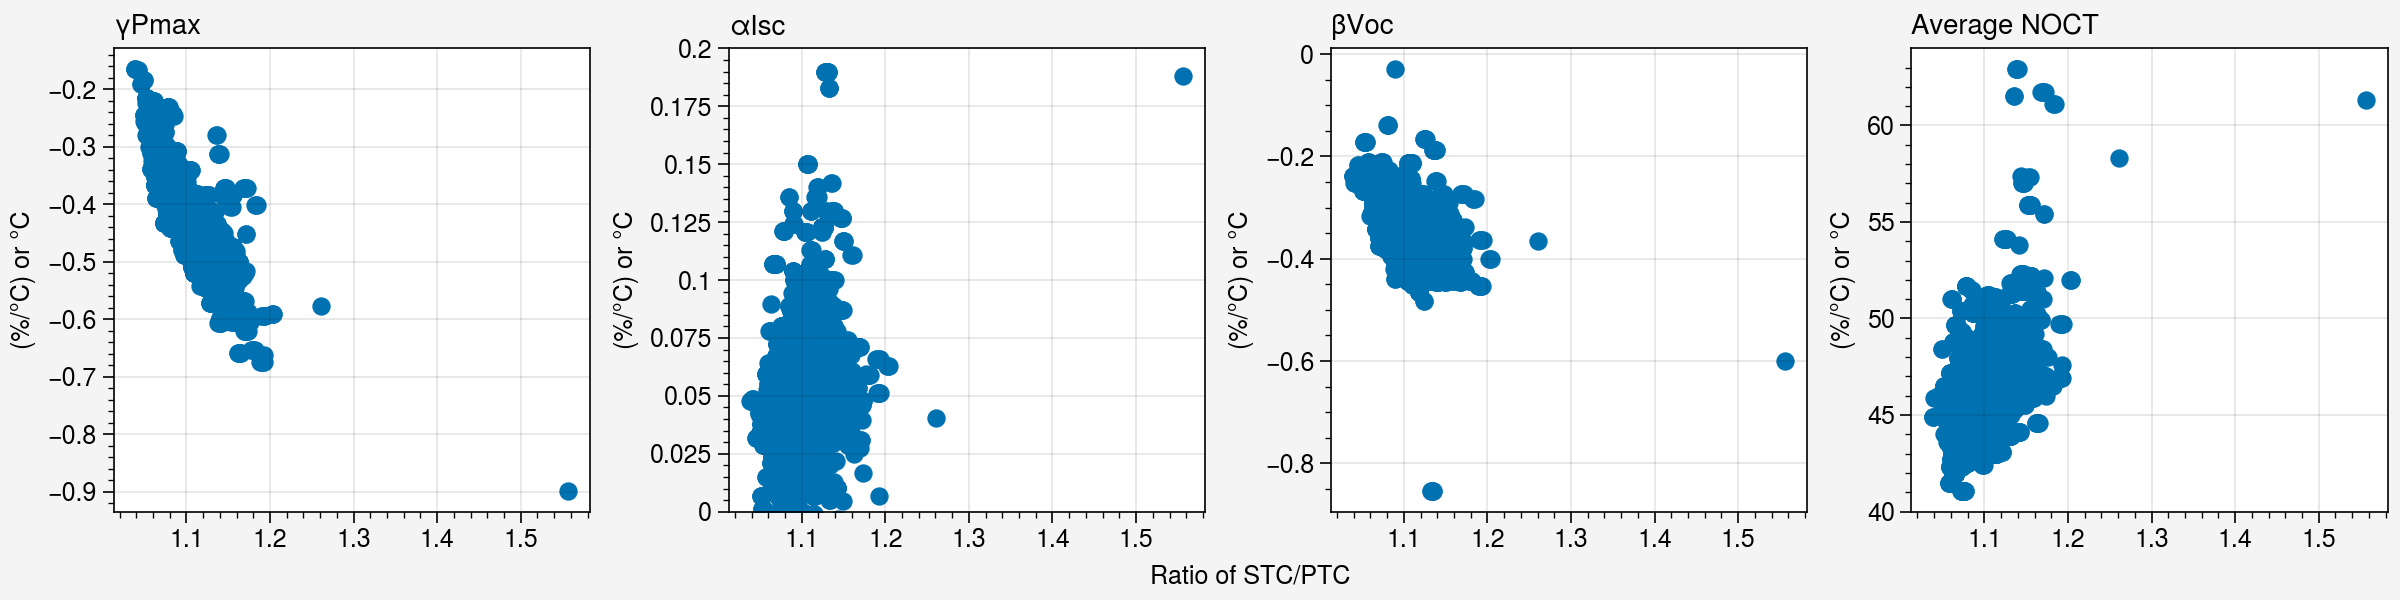

In [74]:
ratio = cec_full["Nameplate Pmax"] / cec_full["PTC"]



fig, axe = pplt.subplots(figsize=(12,3),ncols=4,sharey=False,sharex=True)

ax = axe[0]
ax.scatter(x=ratio,
           y=cec_full['γPmax'].astype(float).values)
ax.format(ltitle="γPmax",
        #   ylim=(0,0.2),
        #   xlim=(1,1.2)
          )

ax = axe[1]
ax.scatter(x=ratio,
           y=cec_full['αIsc'].astype(float).values)
ax.format(ltitle="αIsc",
          ylim=(0,0.2),
        #   xlim=(1,1.2)
          )

ax = axe[2]
ax.scatter(x=ratio,
           y=cec_full['βVoc'].astype(float).values)
ax.format(ltitle="βVoc",
        #   ylim=(0,0.2),
        #   xlim=(1,1.2)
          )

ax = axe[3]
ax.scatter(x=ratio,
           y=cec_full['Average NOCT'].astype(float).values)
ax.format(ltitle="Average NOCT",
        #   ylim=(0,0.2),
        #   xlim=(1,1.2)
          )

axe.format(xlabel='Ratio of STC/PTC',
           ylabel='(%/°C) or °C')

In [56]:
cec_full['Nameplate Voc']

1        38.63
2        38.97
3        39.31
4        39.65
5        39.99
         ...  
17707    45.96
17708    46.12
17709    46.28
17710    46.44
17711     46.6
Name: Nameplate Voc, Length: 17711, dtype: object

# Do CEC data match full list

In [87]:
cec_df.sample()

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
A10Green_Technology_A10J_S72_175,Mono-c-Si,0,175.0914,151.2,1.3,1.576,0.825,72,5.17,43.99,...,1.981696,5.175703,1.149158e-09,0.316688,287.102203,16.057121,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_180,Mono-c-Si,0,179.928,155.7,1.3,1.576,0.825,72,5.31,44.06,...,1.988414,5.316148,1.225242e-09,0.299919,259.047943,16.418983,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_S72_185,Mono-c-Si,0,184.7016,160.2,1.3,1.576,0.825,72,5.43,44.14,...,1.984817,5.435676,1.161638e-09,0.311962,298.424438,15.688233,-0.5072,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_220,Multi-c-Si,0,219.876,189.1,1.624,1.632,0.995,60,7.95,36.06,...,1.673094,7.959062,3.344148e-09,0.140393,123.168404,21.875164,-0.5196,N,SAM 2018.11.11 r2,1/3/2019
A10Green_Technology_A10J_M60_225,Multi-c-Si,0,224.9856,193.5,1.624,1.632,0.995,60,8.04,36.24,...,1.671782,8.047206,3.014237e-09,0.14737,164.419479,20.698376,-0.5196,N,SAM 2018.11.11 r2,1/3/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zytech_Solar_ZT300P,Multi-c-Si,0,300.0032,271.2,1.931,1.95,0.99,72,8.71,45.96,...,1.84441,8.805312,1.314128e-10,0.515735,552.45459,5.415547,-0.4308,N,SAM 2018.11.11 r2,1/3/2019
Zytech_Solar_ZT305P,Multi-c-Si,0,305.0564,275.8,1.931,1.95,0.99,72,8.87,46.12,...,1.849153,8.874016,1.301056e-10,0.506611,1119.067017,5.241555,-0.4308,N,SAM 2018.11.11 r2,1/3/2019
Zytech_Solar_ZT310P,Multi-c-Si,0,310.1436,280.5,1.931,1.95,0.99,72,8.9,46.28,...,1.857403,8.994804,1.348877e-10,0.495904,767.957764,5.446336,-0.4308,N,SAM 2018.11.11 r2,1/3/2019
Zytech_Solar_ZT315P,Multi-c-Si,0,315.0936,285.1,1.931,1.95,0.99,72,9.01,46.44,...,1.865025,9.106614,1.386637e-10,0.488376,682.291748,5.578743,-0.4308,N,SAM 2018.11.11 r2,1/3/2019
